# Definición del problema y objetivos
A continuación realizaremos un análisis del conocido dataset "Titanic" que puede encontrarse en la url https://www.kaggle.com/competitions/titanic/data?select=train.csv.

Este análisis tendrá como objetivos la limpieza de los datos, la descripción de las características más relevantes (tanto en la relación que guardan entre ellas como con la variable objetivo "Surivived") y finalmente la creación de modelos de Machine Learning con el objetivo de predecir si un pasajero tiene mayor o menor probabilidad de superviviencia según el valor en el resto de sus características.

Comenzamos realiazando todas las importaciones de librerías que se utilizarán durante el análisis y definimos 8 funciones reutilizables para diferentes datasets cuya descripción se explica de forma breve en ella. Estas funciones, además, ahorrarán mucho código evitando repeticiones.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, ttest_ind, f_oneway, mannwhitneyu, kruskal, chi2_contingency, pearsonr, spearmanr
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

plt.style.use("ggplot")


def corr_matrix(data, figsize=None):
    """
    Genera un mapa de calor de correlaciones entre todas las variables numéricas de un DataFrame.

    Parámetros:
    - data: DataFrame que contiene los datos a analizar.
    - figsize: tupla opcional para especificar el tamaño de la figura. Si no se indica, se ajusta automáticamente.
    """
    # Seleccionar columnas numéricas
    num_cols = data.select_dtypes(["number"])

    # Calcular tamaño de figura si no se especifica
    if figsize is None:
        figsize = (num_cols.shape[1] * 1.2, num_cols.shape[1] * 0.9)

    # Crear mapa de calor de correlación
    plt.figure(figsize=figsize)
    sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                center=0, square=True, cbar_kws={"shrink": .8}, linewidths=.5)
    plt.title('Matriz de correlación')
    plt.show()



def vars_distribution(data, cols=None, ncols=3, kind='barplot', display_asimetria=True, figsize=[]):
    """
    Grafica la distribución de múltiples variables de un DataFrame en una sola figura. 
    Soporta distintos tipos de gráficos por variable y muestra opcionalmente la asimetría.

    Parámetros:
    - data: DataFrame con los datos.
    - cols: lista de columnas a graficar (por defecto todas).
    - ncols: número de columnas por fila en la figura.
    - kind: tipo de gráfico ('histplot', 'boxplot', etc.) o lista por columna.
    - display_asimetria: si True, muestra tabla con asimetría de variables numéricas.
    - figsize: tamaño de la figura (se ajusta automáticamente si no se especifica).
    """

    # Selección de columnas
    if cols is None:
        cols = data.columns.tolist()

    if ncols > len(cols):
        ncols = len(cols)
    
    nrows = int(np.ceil(len(cols) / ncols))  

    # Tamaño de figura automático si no se especifica
    if figsize == []:
        altura = nrows * (2 if kind == 'boxplot' else 3)
        figsize = (min(len(cols), ncols) * 6, altura)

    # DataFrame para registrar asimetrías
    asimetria = pd.DataFrame(columns=['Asimetria'])

    # Crear figura y ejes
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = np.array(ax).reshape(-1)

    for i, col in enumerate(cols):
        tipo = kind[i] if isinstance(kind, list) else kind

        if tipo in ['histplot', 'barplot', 'countplot'] or data[col].dtype == 'object':
            if data[col].nunique() < 20 or data[col].dtype == 'object':
                x = (data[col].value_counts().sort_values(ascending=False)
                     if data[col].dtype in ['object', 'category']
                     else data[col].value_counts().sort_index())

                sns.barplot(x=x.index, y=x.values, hue=x.index, palette='copper',
                            ax=ax[i], legend=False, errorbar=None)
                ax[i].set_ylim(0, x.max() * 1.1)
                for idx, value in enumerate(x):
                    ax[i].text(idx, value, f'{value/sum(x)*100:.1f}%', ha='center', va='bottom')
            else:
                sns.histplot(data[col], kde=True, ax=ax[i])
        elif tipo == 'boxplot':
            sns.boxplot(x=data[col], ax=ax[i])
        elif tipo == 'violinplot':
            sns.violinplot(x=data[col], ax=ax[i])
        elif tipo == 'kdeplot':
            sns.kdeplot(data[col], ax=ax[i])

        ax[i].set_title(col)
        ax[i].set_xlabel('')

        if data[col].dtype not in [object, bool]:
            asimetria.loc[col, 'Asimetria'] = round(data[col].skew(), 5)

    for j in range(len(cols), len(ax)):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

    if len(asimetria.index) > 0 and display_asimetria:
        display(asimetria.sort_values(by='Asimetria', ascending=False).T)



def normalization_YeoJohnson(data, cols, figsize=[], display=True):
    """
    Aplica la transformación Yeo-Johnson a una o varias columnas de un DataFrame para reducir la asimetría. 
    Crea nuevas columnas con sufijo '_normalized' y permite visualizar las distribuciones antes y después.

    Parámetros:
    - data: DataFrame original.
    - cols: columna o lista de columnas a transformar.
    - figsize: tamaño de la figura para los gráficos (opcional).
    - display: si True, muestra las distribuciones antes y después de la transformación.
    """

    # Convertir string a lista si es necesario
    if isinstance(cols, str):
        cols = [cols]

    # Establecer tamaño de figura si no se ha especificado
    if not figsize:
        figsize = (20, 4 * len(cols))

    cols_graf = []

    for col in cols:
        # Aplicar transformación Yeo-Johnson solo a los valores no nulos
        transformer = PowerTransformer(method='yeo-johnson')
        transformed = transformer.fit_transform(data[col].dropna().values.reshape(-1, 1))

        # Guardar los valores transformados en una nueva columna
        data.loc[data[col].dropna().index, col + '_normalized'] = transformed

        # Guardar columnas originales y transformadas para graficar
        cols_graf.extend([col, col + '_normalized'])

    # Mostrar gráficos si se solicita
    if display:
        vars_distribution(data, cols=cols_graf, ncols=2, kind='histplot', figsize=figsize)



def x_cat_y_cont(data, x_cols, y_cols, kind='boxplot', ncols=4, figsize=[], test=True):
    """
    Visualiza la relación entre variables categóricas (x) y continuas (y) usando distintos tipos de gráficos.
    También permite realizar pruebas estadísticas para evaluar la influencia de las variables categóricas sobre las continuas.

    Parámetros:
    - data: DataFrame con los datos.
    - x_cols: columna(s) categórica(s) a comparar (str o lista).
    - y_cols: columna(s) continua(s) dependiente(s) (str o lista).
    - kind: tipo(s) de gráfico a usar ('boxplot', 'violinplot', 'histplot', etc.).
    - ncols: número de columnas por fila en la visualización.
    - figsize: tamaño del gráfico (opcional).
    - test: si True, realiza contraste de hipótesis entre grupos.
    """

    # Asegurar que x_cols e y_cols sean listas
    if isinstance(x_cols, str): x_cols = [x_cols]
    if isinstance(y_cols, str): y_cols = [y_cols]

    # Generar combinaciones (x, y)
    combos = [(x, y) for x in x_cols for y in y_cols]
    total_plots = len(combos)
    nrows = int(np.ceil(total_plots / ncols))

    # Establecer tamaño de figura si no se ha definido
    if not figsize:
        figsize = (min(total_plots, ncols) * 5, nrows * 4)

    # Crear figura y aplanar los ejes
    fig, ax = plt.subplots(nrows=nrows, ncols=min(total_plots, ncols), figsize=figsize)
    ax = np.array(ax).ravel()

    # Unificar el tipo de gráfico si se da uno solo
    if isinstance(kind, str):
        kind = [kind] * total_plots

    # Preparar tabla para resultados estadísticos si se solicita
    if test:
        resultados_test = pd.DataFrame(columns=['x (cat)', 'y (cont)', 'Estadístico de influencia de x sobre y',
                                               'p-valor de influencia'])

    # Graficar cada combinación y realizar test
    for i, (x_col, y_col) in enumerate(combos):
        k = kind[i]
        if k == 'boxplot':
            sns.boxplot(x=data[x_col], y=data[y_col], ax=ax[i])
        elif k == 'violinplot':
            sns.violinplot(x=data[x_col], y=data[y_col], ax=ax[i])
        elif k == 'stripplot':
            sns.stripplot(x=data[x_col], y=data[y_col], ax=ax[i])
        elif k == 'swarmplot':
            sns.swarmplot(x=data[x_col], y=data[y_col], ax=ax[i])
        elif k == 'histplot':
            sns.histplot(data=data, x=y_col, hue=x_col, ax=ax[i], bins=20, kde=True)
            ax[i].set_xlabel(y_col)
            ax[i].set_ylabel('Count')
        else:
            raise ValueError(f"Tipo de gráfico '{k}' no válido.")

        ax[i].set_title(f'{x_col} vs {y_col}')
        ax[i].set_xlabel(x_col)
        ax[i].set_ylabel(y_col)

        # Contrastes de hipótesis entre categorías
        if test:
            grupos = [g.dropna() for _, g in data.groupby(x_col)[y_col]]
            normalidad = [(shapiro(g)[1] if len(g) >= 3 else 1.0) > 0.05 for g in grupos]
            es_normal = all(normalidad)

            if es_normal:
                if len(grupos) == 2:
                    stat, p_val = ttest_ind(grupos[0], grupos[1])
                    test_name = 't de Student'
                else:
                    stat, p_val = f_oneway(*grupos)
                    test_name = 'ANOVA'
            else:
                if len(grupos) == 2:
                    stat, p_val = mannwhitneyu(grupos[0], grupos[1])
                    test_name = 'Mann-Whitney U'
                else:
                    stat, p_val = kruskal(*grupos)
                    test_name = 'Kruskal-Wallis'

            resultados_test.loc[i] = [x_col, y_col, test_name, p_val]

    # Ocultar subgráficos vacíos
    for j in range(total_plots, len(ax)):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Mostrar tabla de resultados estadísticos si se pidió
    if test:
        display(resultados_test.style.hide(axis="index"))




def x_cat_y_cat(data, y_cols, x_cols=None, ncols=4, rotation=None, figsize=[], kind='heatmap', test=True):
    """
    Representa visualmente la relación entre variables categóricas (x) y una o varias categóricas objetivo (y),
    utilizando heatmaps, countplots o barplots, y opcionalmente realiza pruebas de Chi-cuadrado.

    Parámetros:
    - data: DataFrame con los datos.
    - y_cols: columna(s) categórica(s) objetivo (str o lista).
    - x_cols: columnas categóricas predictoras (opcional, si no se especifica se detectan automáticamente).
    - ncols: número de columnas en el layout de subgráficos.
    - rotation: lista de booleanos o valores para rotar etiquetas del eje x.
    - figsize: tamaño personalizado de la figura.
    - kind: tipo de gráfico ('heatmap', 'barplot', 'countplot').
    - test: si True, muestra p-values del test de Chi-cuadrado.
    """

    corr_cat = pd.DataFrame(columns=["x (cat)", "y (cat)", "Chi2", "p-value"])

    # Selección automática de columnas categóricas si no se proporcionan
    if x_cols is None:
        x_cols = data.nunique()[data.nunique() < 20].index.tolist()
    elif isinstance(x_cols, str):
        x_cols = [x_cols]
    if isinstance(y_cols, str):
        y_cols = [y_cols]

    # Combinaciones de cada x con cada y
    combos = [(x, y) for x in x_cols for y in y_cols]
    total_plots = len(combos)
    nrows = int(np.ceil(total_plots / ncols))

    # Para layout de una fila, ajustar proporciones si se desea
    if nrows == 1 and len(x_cols) > 1:
        with_ratios = [data[col].nunique() for col in x_cols]

    # Tamaño de la figura
    if not figsize:
        if kind == 'heatmap':
            max_ycat = max(data[y].nunique() for _, y in combos)
            figsize = (min(ncols, total_plots) * 5, nrows * max_ycat * 1.2)
        else:
            figsize = (min(ncols, total_plots) * 5, nrows * 3)

    # Crear figura
    if nrows == 1 and len(x_cols) > 1:
        fig, ax = plt.subplots(nrows=nrows, ncols=min(total_plots, ncols), figsize=figsize, width_ratios=with_ratios)
    else:
        fig, ax = plt.subplots(nrows=nrows, ncols=min(total_plots, ncols), figsize=figsize)
    ax = np.array(ax).ravel()

    # Graficar cada combinación
    for i, (x_col, y_col) in enumerate(combos):
        # Tablas de contingencia para gráfico y para test
        crosstab_norm = pd.crosstab(data[x_col], data[y_col], normalize='index')
        crosstab_raw = pd.crosstab(data[x_col], data[y_col])

        # Ordenar categorías si y es binaria
        if data[x_col].dtype == 'object' and data[y_col].dropna().unique().tolist() == [0, 1]:
            order = crosstab_norm[1].sort_values(ascending=False).index.tolist()
            crosstab_norm = crosstab_norm.reindex(order)
        else:
            order = None

        # Dibujar gráfico
        if kind == 'barplot':
            if data[y_col].dropna().unique().tolist() == [0, 1]:
                sns.barplot(data=data, x=x_col, y=y_col, hue=x_col, order=order, hue_order=order,
                            errorbar=None, palette='inferno', ax=ax[i], legend=False)
            else:
                crosstab_norm.plot(kind='bar', ax=ax[i], colormap='copper', alpha=0.7, rot=0)
        elif kind == 'heatmap':
            sns.heatmap(crosstab_norm.T, annot=True, fmt='.2f', cmap='Reds', ax=ax[i])
        elif kind == 'countplot':
            sns.countplot(data=data, x=x_col, hue=y_col, palette='inferno', ax=ax[i], legend=False)
        else:
            raise ValueError(f"Tipo de gráfico '{kind}' no válido. Use 'barplot', 'heatmap' o 'countplot'.")

        ax[i].set_title(f'{x_col} vs {y_col}')
        ax[i].set_xlabel(x_col)
        ax[i].set_ylabel(y_col)

        # Rotar etiquetas si se especifica
        if rotation is not None and i < len(rotation):
            ax[i].tick_params(axis='x', rotation=rotation[i] if isinstance(rotation[i], (int, float)) else 30)

        # Contraste de Chi-cuadrado
        if test:
            chi2, p, _, _ = chi2_contingency(crosstab_raw)
            corr_cat.loc[len(corr_cat)] = [x_col, y_col, chi2, p]

    # Ocultar subplots sobrantes
    for j in range(total_plots, len(ax)):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

    if test:
        display(corr_cat.sort_values(by='p-value', ascending=True).reset_index(drop=True).style.hide(axis="index"))



def x_cont_y_cont(data, x_cols, y_cols, hue=None, kind='scatterplot', ncols=4, figsize=[], test=True):
    """
    Representa gráficamente la relación entre variables continuas usando diferentes tipos de gráficos.
    También realiza pruebas de correlación (Pearson o Spearman) si se desea.

    Parámetros:
    - data: DataFrame con los datos.
    - x_cols: columnas independientes continuas (str o lista).
    - y_cols: columnas objetivo continuas (str o lista).
    - hue: variable categórica opcional para colorear los puntos en scatterplot.
    - kind: tipo de gráfico ('scatterplot', 'regplot', 'lineplot', 'kdeplot') o lista de tipos.
    - ncols: número de columnas en el layout de subplots.
    - figsize: tamaño personalizado de la figura.
    - test: si True, muestra resultados de tests de correlación.
    """

    # Asegurar que x_cols e y_cols son listas
    if isinstance(x_cols, str):
        x_cols = [x_cols]
    if isinstance(y_cols, str):
        y_cols = [y_cols]

    # Crear combinaciones de pares (x, y)
    combos = [(x, y) for x in x_cols for y in y_cols]
    total_plots = len(combos)
    nrows = int(np.ceil(total_plots / ncols))

    # Tamaño de la figura por defecto si no se especifica
    if not figsize:
        figsize = (min(total_plots, ncols) * 5, nrows * 4)

    fig, ax = plt.subplots(nrows=nrows, ncols=min(total_plots, ncols), figsize=figsize)
    ax = np.array(ax).ravel()

    # Si se pasa un solo tipo de gráfico, replicarlo para todas las combinaciones
    if isinstance(kind, str): 
        kind = [kind] * total_plots

    # Inicializar DataFrame para resultados de correlación
    if test:
        resultados_test = pd.DataFrame(columns=['x', 'y', 'Estadístico', 'p-valor'])

    # Iterar sobre cada combinación
    for i, (x, y) in enumerate(combos):
        # Elegir tipo de gráfico
        if kind[i] in ['scatterplot', 'regplot']:
            if hue:
                sns.scatterplot(data=data, x=x, y=y, hue=hue, ax=ax[i], palette='inferno')
            else:
                sns.regplot(data=data, x=x, y=y, ax=ax[i], color='blue', line_kws={'color':'red'})
        elif kind[i] == 'lineplot':
            sns.lineplot(data=data, x=x, y=y, ax=ax[i])
        elif kind[i] == 'kdeplot':
            sns.kdeplot(data=data, x=x, y=y, ax=ax[i], cmap='Blues', fill=True)
        else:
            raise ValueError(f"Tipo de gráfico '{kind[i]}' no válido. Use 'scatterplot', 'regplot', 'lineplot' o 'kdeplot'.")

        ax[i].set_xlabel(x)
        ax[i].set_ylabel(y)

        # Realizar test de correlación si test=True
        if test:
            # Comprobar normalidad con Shapiro-Wilk
            stat_x, p_x = shapiro(data[x].dropna())
            stat_y, p_y = shapiro(data[y].dropna())
            es_normal = (p_x > 0.05) and (p_y > 0.05)

            # Selección de test
            if es_normal:
                stat, p_valor = pearsonr(data[[x, y]].dropna())
                test_name = 'Pearson'
            else:
                stat, p_valor = spearmanr(data[[x, y]].dropna())
                test_name = 'Spearman'

            resultados_test.loc[len(resultados_test)] = [x, y, test_name, p_valor]

    # Ocultar subgráficos vacíos
    for j in range(total_plots, len(ax)):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Mostrar resultados del test si corresponde
    if test:
        display(resultados_test.reset_index(drop=True).drop_duplicates(subset=['x', 'y']).style.hide(axis="index"))



def preprocessor_creator(OrdinalE_cols=[], RScaler_cols=[], PowerT_cols=[], OH_cols=[], OH_drop=None, verbose_feature_names_out=False):
    """
    Crea un preprocesador para un pipeline de scikit-learn aplicando transformaciones específicas a columnas designadas.
    
    Parámetros:
    - OrdinalE_cols: columnas a transformar con OrdinalEncoder.
    - RScaler_cols: columnas a escalar con RobustScaler.
    - PowerT_cols: columnas a normalizar con PowerTransformer (Yeo-Johnson).
    - OH_cols: columnas a codificar con OneHotEncoder.
    - OH_drop: parámetro 'drop' de OneHotEncoder ('first', None...).
    - verbose_feature_names_out: controla el nombre de las columnas tras la transformación.

    Devuelve:
    - Un ColumnTransformer que puede usarse en un pipeline.
    """
    transformers = []

    # Detectar columnas que requieren tanto PowerTransformer como RobustScaler
    PowerT_and_RScaler_cols = list(set(RScaler_cols) & set(PowerT_cols))
    RScaler_cols = list(set(RScaler_cols) - set(PowerT_and_RScaler_cols))
    PowerT_cols = list(set(PowerT_cols) - set(PowerT_and_RScaler_cols))

    # Transformador para codificación ordinal
    if OrdinalE_cols:
        transformers.append(("Ordinal", OrdinalEncoder(), OrdinalE_cols))

    # Transformador para codificación OneHot (útil para modelos lineales o para representar variables categóricas)
    if OH_cols:
        transformers.append(("OneHot", OneHotEncoder(drop=OH_drop), OH_cols))

    # Transformador para normalización mediante Yeo-Johnson
    if PowerT_cols:
        transformers.append(("PowerT", PowerTransformer(), PowerT_cols))

    # Transformador para escalado robusto (resistente a outliers)
    if RScaler_cols:
        transformers.append(("RScaler", RobustScaler(), RScaler_cols))

    # Transformador combinado si una columna requiere ambos: PowerTransformer y RobustScaler
    if PowerT_and_RScaler_cols:
        transformers.append(("PowerT_and_RScaler", Pipeline(steps=[
            ('PowerT', PowerTransformer()),
            ('RScaler', RobustScaler())
        ]), PowerT_and_RScaler_cols))

    # Componer el ColumnTransformer final con el resto de columnas como 'passthrough'
    preprocessor = ColumnTransformer(transformers=transformers,
                                     remainder='passthrough',
                                     verbose_feature_names_out=verbose_feature_names_out)
    return preprocessor




def trainer(X_train, y_train, models, cv=5, X_val=None, y_val=None, scoring='f1', resultados_sorted=True, verbose=True):
    """
    Entrena múltiples modelos de clasificación utilizando validación cruzada o validación hold-out.
    
    Parámetros:
    - X_train, y_train: datos de entrenamiento.
    - models: lista de tuplas (nombre, estimador, preprocesador, param_grid).
    - cv: número de folds para la validación cruzada.
    - X_val, y_val: datos de validación (opcional). Si se proporcionan, se usa como evaluación externa.
    - scoring: métrica principal para GridSearchCV y ordenación ('f1' por defecto).
    - resultados_sorted: si True, ordena los resultados según la métrica principal.
    - verbose: si True, muestra métricas, matriz de confusión y mejores parámetros.

    Devuelve:
    - entrenados: diccionario con los modelos entrenados.
    - Muestra un DataFrame con las métricas de evaluación.
    """
    resultados = pd.DataFrame()        # Tabla de resultados de métricas por modelo
    entrenados = {}                    # Diccionario para almacenar los modelos entrenados
    cv_inner = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)  # División estratificada

    metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']  # Métricas a calcular

    for name, estimator, preprocessor, param_grid in models:
        # 1. Crear pipeline con preprocesador y modelo
        pipeline = Pipeline([('pre', preprocessor), ('model', estimator)])

        # 2. Si hay grid de parámetros, usar GridSearchCV para buscar la mejor combinación
        if param_grid is not None:
            gs = GridSearchCV(pipeline, param_grid, cv=cv_inner,
                              scoring=scoring, return_train_score=False,
                              verbose=0, n_jobs=-1)
            gs.fit(X_train, y_train)
            entrenados[name] = gs
            final_est = gs.best_estimator_
            best_params = gs.best_params_
        else:
            pipeline.fit(X_train, y_train)
            entrenados[name] = pipeline
            final_est = pipeline
            best_params = None

        # 3. Evaluación del modelo
        if X_val is None or y_val is None:
            # Si no hay validación externa, se realiza validación cruzada
            cv_res = cross_validate(final_est, X_train, y_train,
                                    cv=cv_inner, scoring=metrics, n_jobs=-1)
            resultados.loc[name, ['F1', 'Accuracy', 'Precission', 'Recall', 'AUC']] = [
                np.mean(cv_res[f'test_{m}']) for m in metrics
            ]
        else:
            # Si se proporcionó conjunto de validación, se evalúa directamente sobre él
            y_pred = entrenados[name].predict(X_val)
            try:
                y_proba = entrenados[name].predict_proba(X_val)[:, 1]
            except AttributeError:
                y_proba = entrenados[name].decision_function(X_val)

            resultados.loc[name, 'F1_val'] = f1_score(y_val, y_pred)
            resultados.loc[name, 'Accuracy_val'] = accuracy_score(y_val, y_pred)
            resultados.loc[name, 'Precision_val'] = precision_score(y_val, y_pred)
            resultados.loc[name, 'Recall_val'] = recall_score(y_val, y_pred)
            resultados.loc[name, 'AUC_val'] = roc_auc_score(y_val, y_proba)

        # 4. Mostrar resultados por pantalla
        if verbose:
            val_col = 'F1' if X_val is None else 'F1_val'
            print(f'➡️ Entrenado {name}: {val_col} = {resultados.loc[name, val_col]:.4f}')
            if best_params is not None:
                print("   ✨ Mejores parámetros:")
                display(pd.DataFrame([best_params]))
            if X_val is not None and y_val is not None:
                cm = confusion_matrix(y_val, y_pred)
                display(pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1']))
                print('-' * 80)

    # 5. Ordenar y mostrar tabla de resultados
    if resultados_sorted:
        sort_col = 'F1' if X_val is None else 'F1_val'
        resultados = resultados.sort_values(by=sort_col, ascending=False)

    display(resultados)
    return entrenados


# Carga de datos

Los datos obtenidos de https://www.kaggle.com/competitions/titanic/data?select=train.csv continene un archivo train.csv y uno test.csv. El de train continene 891 entradas etiquetadas con la columna "Survived" y el de test 418 sin etiquetar.

Las características son las siguientes.
- PassangerId: número de pasagero. Lo convertimos en índice.
- Survived: 0 -> No, 1 -> Sí.
- Pclass: Puede ser ticket de 1ª clase, 2ª clase o 3ª clase.
- Nombre
- SibSp: Número de hermanos o pareja a bordo
- Parch: Número de padres o hijos a bordo.
- Ticket: Número de ticket.
- Fare: Coste del ticket.
- Cabin: Número de cabina.
- Embarked: Puerto de embarcación. C = Cherbourg, Q = Queenstown, S = Southampton.

Cargamos los datos, mostramos información sobre ellos y eliminamos las filas repetidas.

In [2]:
data = pd.read_csv("train.csv")
data_test = pd.read_csv('test.csv')

data.index = data.pop('PassengerId')
data_test.index = data_test.pop('PassengerId')
display(data, data_test)

data.info()
display(pd.Series(data.isnull().sum(), name="Nulos train"), pd.Series(data_test.isnull().sum(), name="Nulos test"))

for col in data.columns:
    print(f'{col}: {data[col].nunique()} valores únicos')

print('\nFilas antes de eliminar duplicados:', data.shape[0])
data.drop_duplicates(inplace=True)
print('Filas después de eliminar duplicados:', data.shape[0])

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Name: Nulos train, dtype: int64

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
Name: Nulos test, dtype: int64

Survived: 2 valores únicos
Pclass: 3 valores únicos
Name: 891 valores únicos
Sex: 2 valores únicos
Age: 88 valores únicos
SibSp: 7 valores únicos
Parch: 7 valores únicos
Ticket: 681 valores únicos
Fare: 248 valores únicos
Cabin: 147 valores únicos
Embarked: 3 valores únicos

Filas antes de eliminar duplicados: 891
Filas después de eliminar duplicados: 891


# Tratamiento de valores nulos y selección de características

Rellenamos los dos valores faltantes de Embarked con su valor más común y el valor de Fare faltante de test con la media. 
Posteriormente eliminamos la columna de Name debido a que no aporta nada importante. Igual con Ticketpues tiene 681 valores diferentes.
Cabin tiene un 687 valores nulos de 891, además de tener 147 valores diferentes de entre los 104 posibles. Así que lo mejor es eliminarla.

In [3]:
data.loc[data['Embarked'].isnull(),'Embarked'] = data['Embarked'].mode()[0]
data_test.loc[data_test['Fare'].isnull(),'Fare'] = data['Fare'].mean()
data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
data_test.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

data.head(6)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
6,0,3,male,NaN,0,0,8.4583,Q


Por ahora, para trabajar con todos los datos unimos los conjuntos de train y test para tener una compresión más detallada de los datos. Luego podrá recuperarse de forma simple extrayendo los primeros 891 valores de train y los últimos para test cuando se requieran hacer predicciones.

In [4]:
data = pd.concat([data, data_test], axis=0)

El resto de valores nulos pertenecen a 'Age'. Sin embargo, crearemos una variable 'data_imputed' aparte de 'total_date'. Esto es debido a que durante el análisis exploratorio, pueden verse modificados los resultados relacionados con la variable 'Age' y perjudicar así la comprensión de los datos si estos valores se imputan. En los momentos que sea necesario tener los valores imputados, como en el caso de entrenamiento de modelos, utilizaremos 'data_imputed'. 

Por otro lado, una variable que puede ser interesante añadir es 'Age_missing' para así ver las características comunes que tienen aquellos pasajeros cuya edad sea desconocida.

Para el caso de 'data_imputed', los datos se imputarán por la mediana.

In [5]:
data['Age_missing'] = data['Age'].isnull()

data_imputed = data.copy()
data_imputed.fillna({'Age': data_imputed['Age'].median()}, inplace=True)

print(f"Cantidad de nulos en data: {data.drop('Survived', axis=1).isnull().sum().sum()}")
print(f"Cantidad de nulos en data_imputed: {data_imputed.drop('Survived', axis=1).isnull().sum().sum()}")

Cantidad de nulos en data: 263
Cantidad de nulos en data_imputed: 0


Finalmente, creamos primero una variable 'Family' que sea la suma de 'SibSp' y 'Parch' y la agruparemos en 'Alone' (0 personas con el pasajero), 'Couple' (1 persona con el pasajero), 'Small' (hasta 3) y 'Large' (el resto).

También crearemos una variable Age_group que agrupe los pasajeros por edades en 'Child' (menos de 12), 'Teen' (entre 12 y 18), 'Adult' (entre 18 y 65) y 'Elder' (mayor a 65), que probablemente sea una variable más interesante al comparar que todos los valores de 'Age' de forma independiente.

Después veremos si es más interesante mantener las dos por separado o en una conjunta. 

In [6]:
data['Family'] = data['SibSp'] + data['Parch']
data_imputed['Family'] = data_imputed['SibSp'] + data_imputed['Parch']

data['Family'] = pd.cut(data['Family'], bins=[-1, 0, 1, 3, 50], labels=['Alone', 'Couple', 'Small', 'Large']).astype('object')
data_imputed['Family'] = pd.cut(data_imputed['Family'], bins=[-1, 0, 1, 3, 50], labels=['Alone', 'Couple', 'Small', 'Large']).astype('object')

data['Age_group'] = pd.cut(data['Age'], bins=[-1, 4, 12, 18, 40, 65, 100], labels=['Baby', 'Child', 'Teen', 'Young_adult', 'Elder_adult', 'Elder']).astype('object')
data_imputed['Age_group'] = pd.cut(data_imputed['Age'], bins=[-1, 4, 12, 18, 40, 65, 100], labels=['Baby', 'Child', 'Teen', 'Young_adult', 'Elder_adult', 'Elder']).astype('object')

## Análisis exploratorio

### Análisis univariante

A continuación utilizamos la función num_distribution para graficar la distribución de las variables numéricas. Primero se grafican histogramas para todas las variables numéricas para así obtener una visión general de la distribución de cada variable.

Después se grafican boxplots para las variables 'Age' y 'Fare' para observar la presencia de outliers.

In [7]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_missing,Family,Age_group
PassengerId,,,,,,,,,,,
1,0.0,3,male,22.0,1,0,7.2500,S,False,Couple,Young_adult
2,1.0,1,female,38.0,1,0,71.2833,C,False,Couple,Young_adult
3,1.0,3,female,26.0,0,0,7.9250,S,False,Alone,Young_adult
4,1.0,1,female,35.0,1,0,53.1000,S,False,Couple,Young_adult
5,0.0,3,male,35.0,0,0,8.0500,S,False,Alone,Young_adult
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,male,NaN,0,0,8.0500,S,True,Alone,NaN
1306,NaN,1,female,39.0,0,0,108.9000,C,False,Alone,Young_adult
1307,NaN,3,male,38.5,0,0,7.2500,S,False,Alone,Young_adult


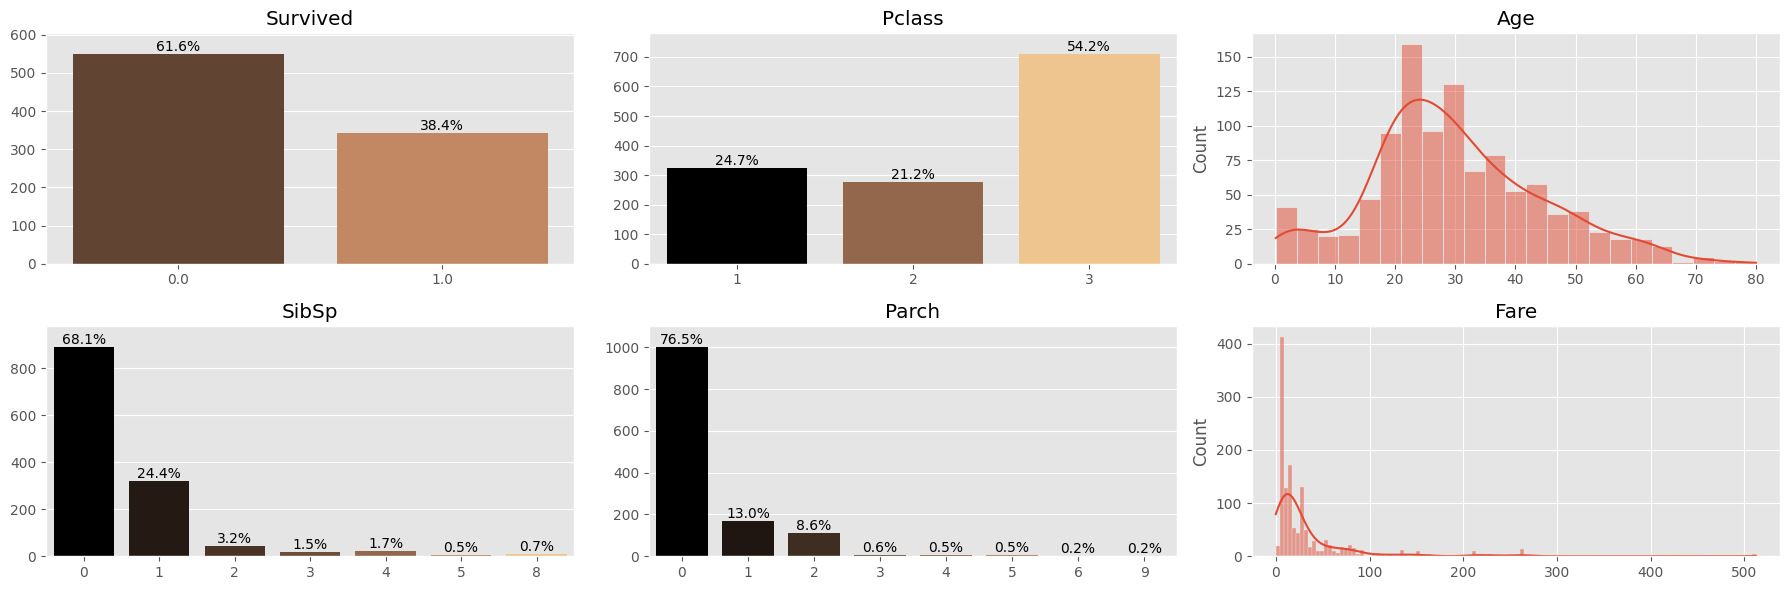

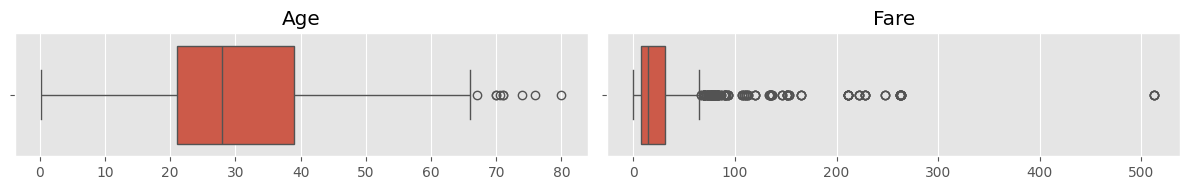

,Fare,Age
Asimetria,4.36942,0.40767


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1309.000000
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.294646
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.738888
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Supervivientes: 342 (26.13%)
Porcentaje de clase 1: 24.68%
Porcentaje de clase 2: 21.16%
Porcentaje de clase 3: 54.16%


In [8]:
# Para trabajar con todos los datos, unimos los conjuntos de train y test.
vars_distribution(data, cols=['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], kind='histplot', display_asimetria=False)
vars_distribution(data, cols=['Age', 'Fare'], kind='boxplot')

display(data.describe())
print(f'Supervivientes: {data[data["Survived"] == 1].shape[0]} ({data[data["Survived"] == 1].shape[0] / data.shape[0] * 100:.2f}%)')
print(f'Porcentaje de clase 1: {data[data["Pclass"] == 1].shape[0] / data.shape[0] * 100:.2f}%')
print(f'Porcentaje de clase 2: {data[data["Pclass"] == 2].shape[0] / data.shape[0] * 100:.2f}%')
print(f'Porcentaje de clase 3: {data[data["Pclass"] == 3].shape[0] / data.shape[0] * 100:.2f}%')

Podemos destacar varias particularidades:

* En total sobrevivió un 26.13% de los pasajeros (teniendo en cuenta solo los valores de train conocidos).
* La mayoría tienen ticket de clase 3 (54%), teniendo por otro lado más o menos la misma cantidad de clase 1 como de la 2 (25% y 21%).
* La mitad de los pasajeros son adultos con edades comprendidas entre los 21 y los 39 años, con media de 29.
* 'Fare' cuenta con una distribución bastante asimétrica (coeficiente de asimetría alto, 4.37), lo que podría perjudicar a algunos modelos al ajustarse (como regresión logística). Añadimos la variable 'Fare_normalized' que aplique la transformación de Yeo-Jhonson a 'Fare', aunque por ahora mantendermos ambas versiones y después elegiremos. 'Age' tiene una baja asimetría para realizar la transformación
* Viendo el Boxplot de 'Age', no se ve ningún outlier fuera de lo normal. En cambio 'Fare' si que tiene un valor muy alejado del resto. Veamos los valores con mayor coste de 'Fare' por si no fuera un valor único.

In [9]:
data.sort_values(by='Fare', ascending=False).head(8)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_missing,Family,Age_group
PassengerId,,,,,,,,,,,
1235,NaN,1,female,58.0,0,1,512.3292,C,False,Couple,Elder_adult
680,1.0,1,male,36.0,0,1,512.3292,C,False,Couple,Young_adult
738,1.0,1,male,35.0,0,0,512.3292,C,False,Alone,Young_adult
259,1.0,1,female,35.0,0,0,512.3292,C,False,Alone,Young_adult
961,NaN,1,female,60.0,1,4,263.0000,S,False,Large,Elder_adult
28,0.0,1,male,19.0,3,2,263.0000,S,False,Large,Young_adult
945,NaN,1,female,28.0,3,2,263.0000,S,False,Large,Young_adult
342,1.0,1,female,24.0,3,2,263.0000,S,False,Large,Young_adult


Al parecer, 512 sea casi el doble de su valor anterior 263, existen cuatro tickets con este precio, lo que me inclina a no descartarlos, aunque sean sorprendentes.

A continuación añadimos la columna 'Fare_normalized' para reducir la asimetría de 'Fare'. 

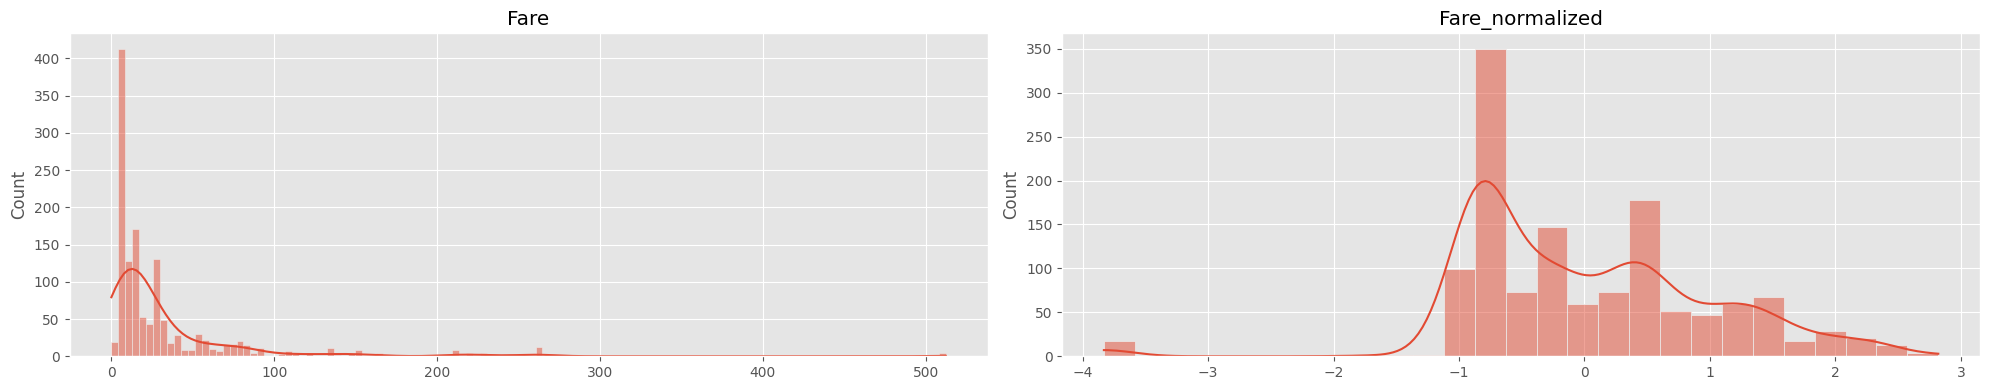

,Fare,Fare_normalized
Asimetria,4.36942,-0.0566


In [10]:
normalization_YeoJohnson(data, ['Fare'])
normalization_YeoJohnson(data_imputed, ['Fare'], display=False)

A continuación representamos las distribuciones de las variables categóricas.

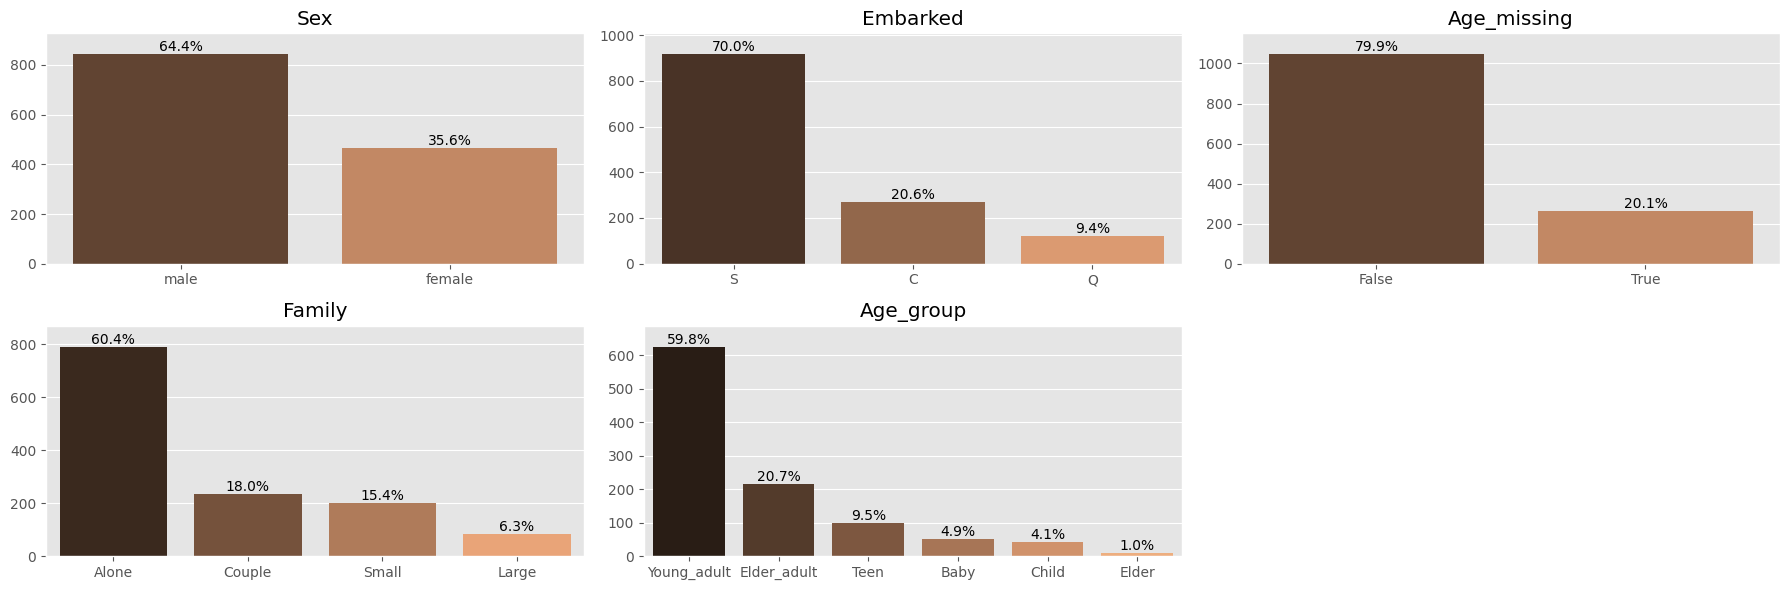

In [11]:
vars_distribution(data, cols=['Sex', 'Embarked', 'Age_missing', 'Family', 'Age_group'], ncols=3, kind='countplot')

Podemos destacar que
* Casi dos de cada tres de los pasajeros son hombres.
* Un 70% de las embarcaciones han sido por Southampton, y tan solo un 9.4% de Queenstown.
* Se desconoce la edad de un 20% de los pasajeros. Esto puede que tenga relación con la supervivencia.
* Un 60% de los viajeros viajan solos, un 18% con alguien y un 22% viajan con más de 1 persona.
* La gran mayoría son adultos de entre 18 y 40.

### Análisis bivariante

Imprimimos la matriz de correlación de las variables numéricas.

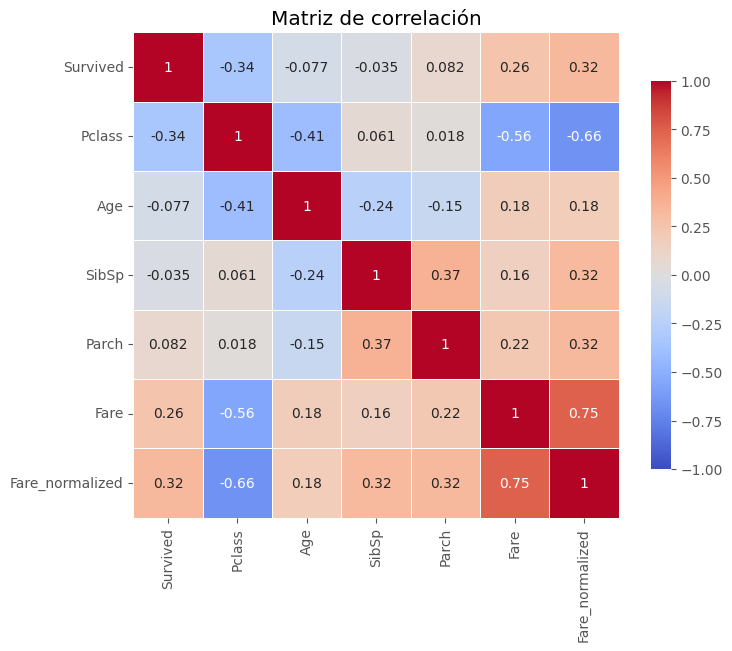

In [12]:
corr_matrix(data)

Analizando la matriz de correlación podemos ver varias cosas:

* Las variables con mayor influencia en la supervivencia, en el sentido univariante, son 'Pclass' y 'Fare' (y su versión transformada), teniendo 'Age', 'SibSp' y 'Parch' un valor sorprendentemente bajo. 
* A mayor es la clase, menor es el coste del ticket y menor tiende a ser la probabilidad de superviviencia.
* Como es de esperar, 'Fare' y 'Fare_normalized' tienen una correlación muy alta. Para evitar multicolinealidad al predecir después deberemos seleccionar entre ellas.
* Al normalizar la variable 'Fare' con una alta asimetría, hemos aumentado de 0.26 de correlación con 'Survived' a 0.32 aplicar la transformación Yeo-Johnson. También ha aumentado su correlación absoluta con 'Pclass', 'SibSp' y 'Parch'.

#### Relaciones con la variable 'Survived'

Veamos la influencia de 'Age', 'Fare' y 'Fare_normalized' en Survived mediante gráficos de boxplot ('Pclass', 'SibSp' y 'Parch' tienen distribuciones discretas y los gráficos carecen de sentido).

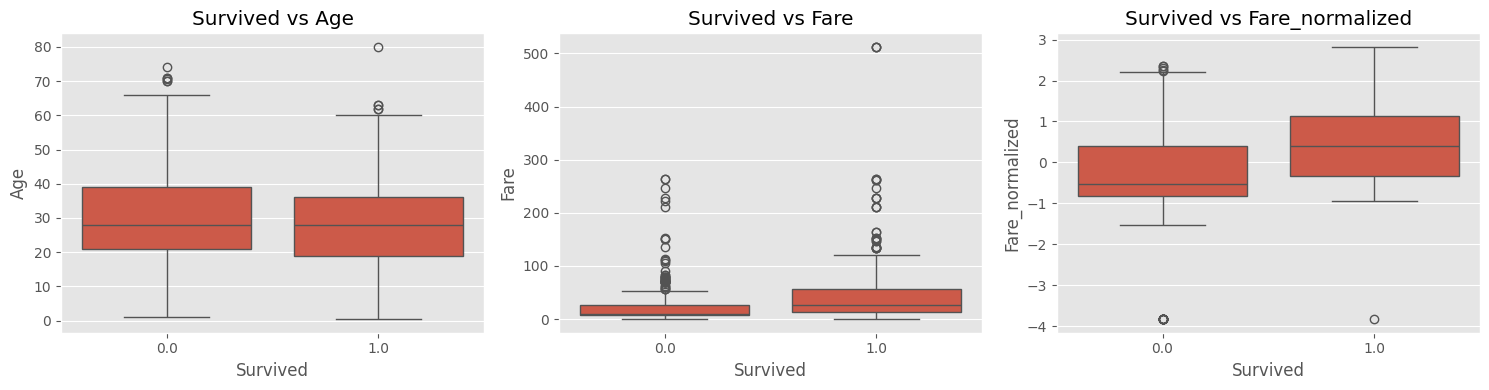

x (cat),y (cont),Estadístico de influencia de x sobre y,p-valor de influencia
Survived,Age,Mann-Whitney U,0.160493
Survived,Fare,Mann-Whitney U,0.000000
Survived,Fare_normalized,Mann-Whitney U,0.000000


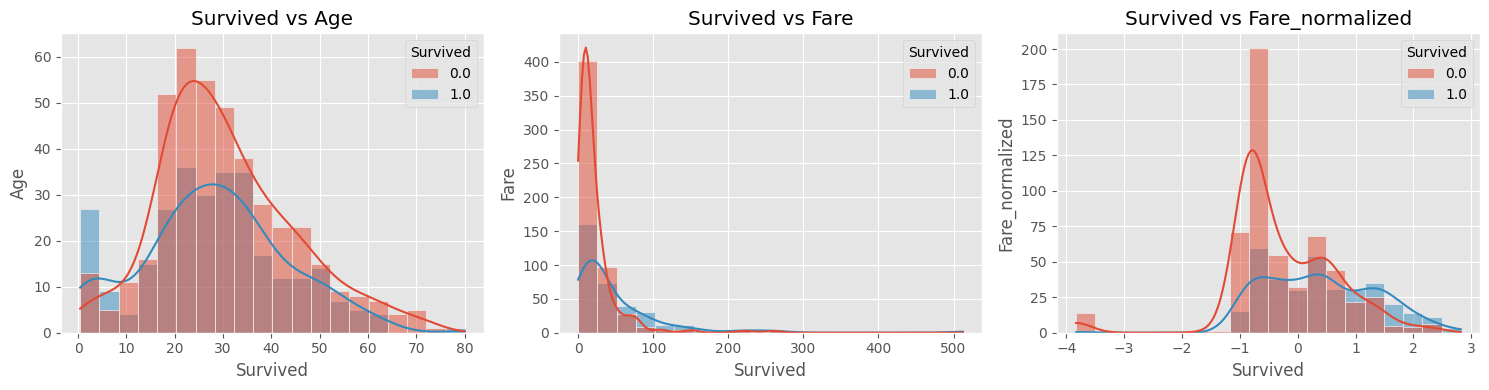

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0.0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1.0,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


In [13]:
x_cat_y_cont(data, y_cols=['Age', 'Fare', 'Fare_normalized'], x_cols='Survived', kind='boxplot', ncols=3)
x_cat_y_cont(data, y_cols=['Age', 'Fare', 'Fare_normalized'], x_cols='Survived', kind='histplot', ncols=3, test=False)
display(pd.DataFrame(data.groupby('Survived')['Fare'].describe()))

* La variable 'Age' tiene un p-valor de 0.16 en el contraste de diferencia de medias de edad entre supervivientes y no supervivientes. Esto implica que no se puede afirmar que 'Age' sea influyente en la superviviencia por tener un p-valor tan alto. Esto tiene sentido al ver los boxplots.
* Tanto las variables 'Fare' como 'Fare_normalized' tienen un p-valor de 0.000000, por lo que cláramente tienen una fuerte influencia en la supervivencia. Esto se puede apreciar en los Boxplots de 'Fare_normalized' ('Ya que en 'Fare' la distribución es muy asimétrica), ya que la caja de los supervivientes es mayor que las de los no supervivientes. Además, como se muestra en la tabla y en el gráfico, los costes de billete de los supervivientes son mucho mayores que los de los no supervivientes. 'Fare' parece ser una variable muy relevante.
* Ni 'Age', ni 'Fare' ni 'Fare_normalized' tienen distribuciones cercanas a una normal (p-valor<0.005).

En resumen, en un sentido bivariante, la variable 'Age' parece tener poca influencia en la supervivencia, pero si se puede ver claramente que aquellos con billete más caro sobreviven más, corroborado por la gráfica entre 'Pclass' y 'Survived' de más abajo.

Estudiamos ahora la relación con las variables categóricas.

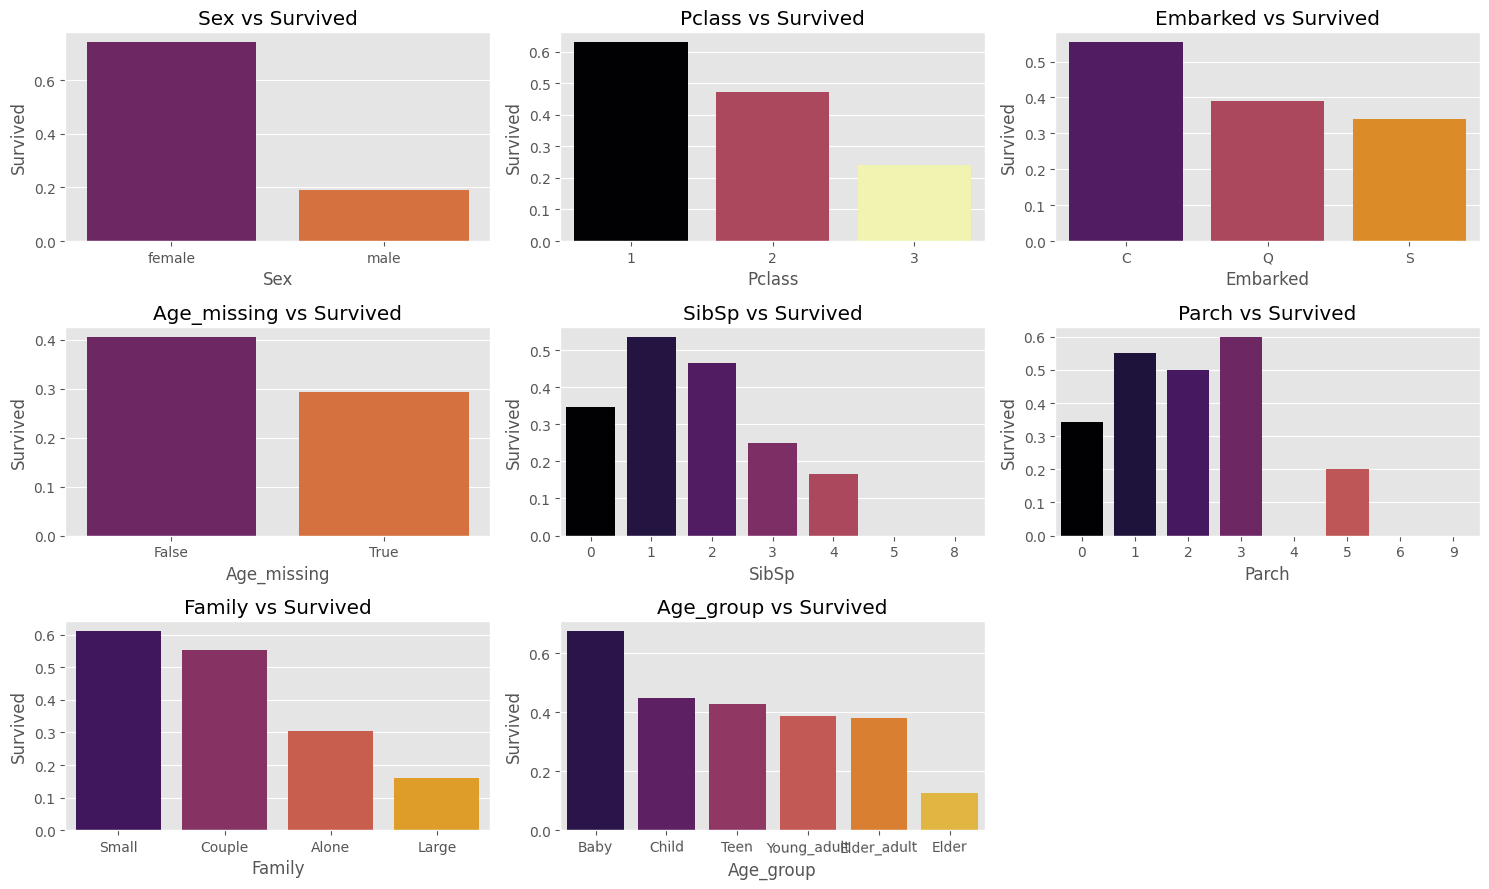

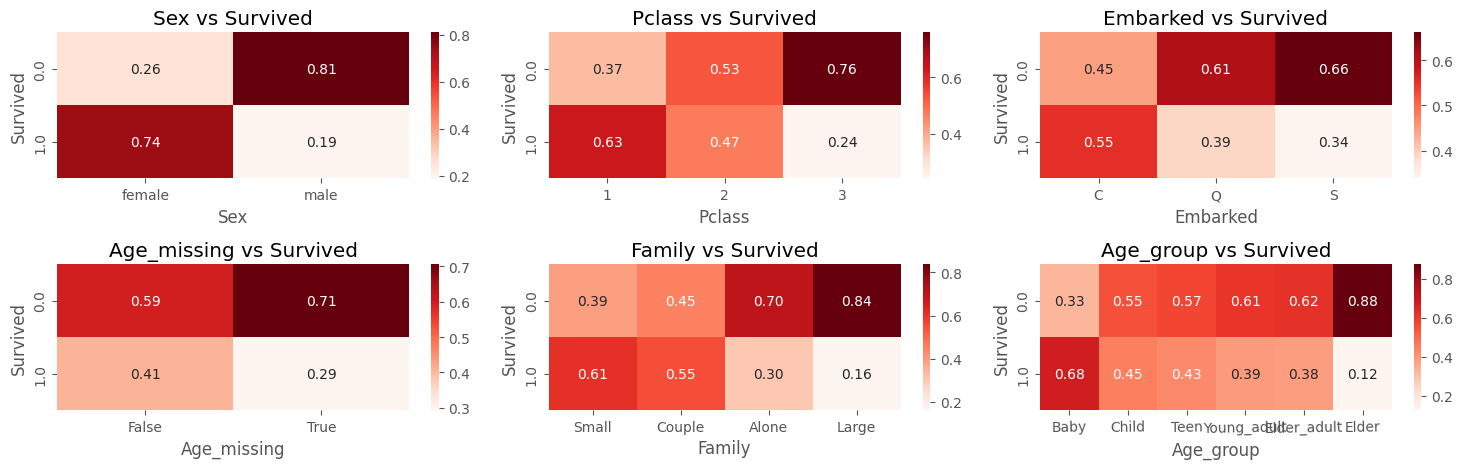

x (cat),y (cat),Chi2,p-value
Sex,Survived,260.717020,0.000000
Pclass,Survived,102.888989,0.000000
Family,Survived,75.560797,0.000000
Embarked,Survived,25.964453,0.000002
Age_group,Survived,15.927597,0.007054
Age_missing,Survived,7.105975,0.007683


In [14]:
x_cat_y_cat(data, y_cols='Survived', x_cols=['Sex', 'Pclass', 'Embarked', 'Age_missing', 'SibSp', 'Parch', 'Family', 'Age_group'],
            kind='barplot', ncols=3, test=False, rotation=[False, False, False, False, False, False, False, True])
x_cat_y_cat(data, y_cols='Survived', x_cols=['Sex', 'Pclass', 'Embarked', 'Age_missing', 'Family', 'Age_group'], kind='heatmap', 
            ncols=3, rotation=[False, False, False, False, False, True])

* Hay una enorme diferencia entre la proporción de supervivientes respecto al sexo. Un 81% de las mujeres sobreviven, en comparación al 19% de los hombres. Esto deja un p-valor de practicamente nulo en el test Chi2 de diferencia entre grupos.
* De forma similar ocurre con 'Pclass'. Podemos ver gran diferencia en sus barras, mostrando un 63% de supervivencia para la 1ª clase, un 47% para la segunda y un 24% para la tercera, dejando un p-valor casi nulo.
* Respecto al puerto de Embarcación, Cherbourg tiene un 55% de supervivencia, en comparación a un 0.39/0.34 de los otros dos puertos. No es una diferencia muy marcada, pero es relevante.
* Los pasajeros cuya edad es desconocida tienen un 12% menos de supervivincia. Esto tiene sentido, pues es normal conocer menos edades de los pasajeros fallecidos que la de los supervivientes.
* Podemos ver que quienes más probabilidad tenían de sobrevivir son los grupos pequeños y las parejas (pasajeros acompañados por una persona).
* Como es de esperar, el grupo cuya supervivencia se priorizaba más son los bebés, seguidos de los niños, adolescentes y adultos. Un dato impactante es que solo el 12% ed los ancianos sobrevivieron.
* El test refleja que todas las variables son relevantes, siendo la que más 'Sex', luego 'Family', luego 'Embarked', luego 'Age_group' y finalmente 'Age_missing'.

Como conclusión en la relación de las variables contínuas y categóricas respecto a 'Survived', a priori parece que el perfil que tiene mayor probabilidad de superviviencia es mujer, de primera clase, proveniente de Cherbourg, edad conocida y con no más de 3 personas acompañándola. 

In [15]:
print("Porcentaje de mujeres que viajaban en primera clase y embarcaron en Cherbourg con familia pequeña o pareja que sobrevivieron:")
perfil_superviviente = data_imputed.dropna().query("Pclass == 1 and Sex == 'female' and Embarked == 'C' and Family in ['Couple', 'Small']")
print(f"{len(perfil_superviviente)} casos de {len(perfil_superviviente.query('Survived == 1'))}: {len(perfil_superviviente.query('Survived == 1')) / len(perfil_superviviente) * 100:.2f}%.")

print("Si no tenemos en cuenta el puerto de embarcación:")
perfil_superviviente = data_imputed.dropna().query("Pclass == 1 and Sex == 'female' and Family in ['Couple', 'Small']")
print(f"{len(perfil_superviviente)} casos de {len(perfil_superviviente.query('Survived == 1'))}: {len(perfil_superviviente.query('Survived == 1')) / len(perfil_superviviente) * 100:.2f}%.")

Porcentaje de mujeres que viajaban en primera clase y embarcaron en Cherbourg con familia pequeña o pareja que sobrevivieron:
23 casos de 23: 100.00%.
Si no tenemos en cuenta el puerto de embarcación:
56 casos de 54: 96.43%.


#### Respecto a la variable Fare y Pclass

Graficamos la distribución de 'Age' frente a 'Fare' (ya que con 'Fare_normalized' hace una curva perfecta) y respecto a las variables categóricas o discretas graficamos boxplots de 'Sex', 'Pclass', 'Embarked', 'Age_missing' y 'Family'.

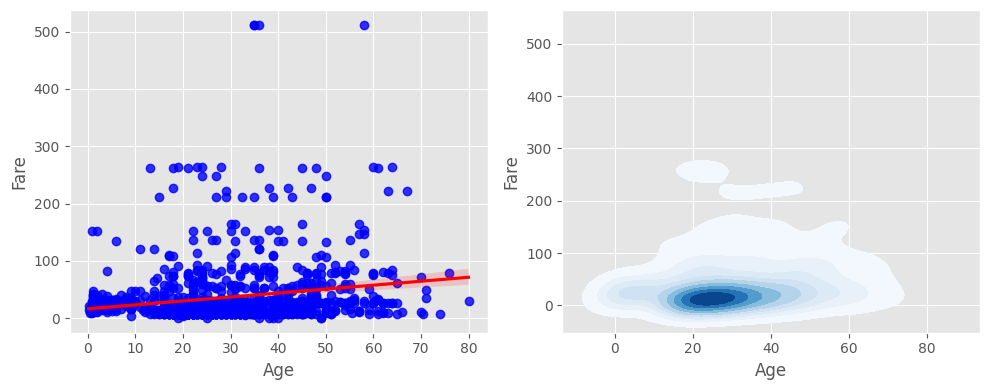

x,y,Estadístico,p-valor
Age,Fare,Spearman,0.000000


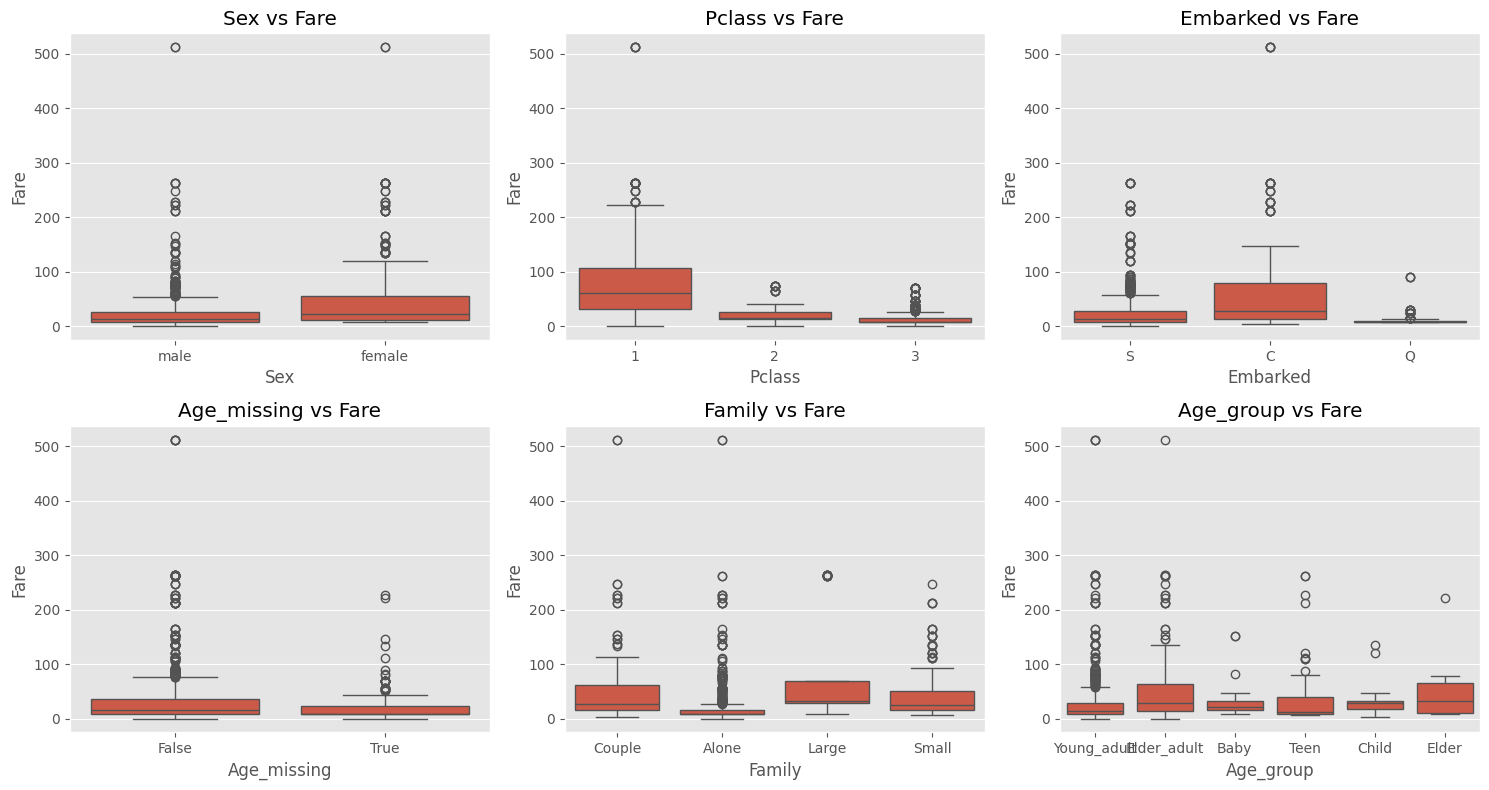

x (cat),y (cont),Estadístico de influencia de x sobre y,p-valor de influencia
Sex,Fare,Mann-Whitney U,0.000000
Pclass,Fare,Kruskal-Wallis,0.000000
Embarked,Fare,Kruskal-Wallis,0.000000
Age_missing,Fare,Mann-Whitney U,0.000000
Family,Fare,Kruskal-Wallis,0.000000
Age_group,Fare,Kruskal-Wallis,0.000000


Promedio de costes:
-------------------
Mujeres: 46.20. Hombres: 26.16.
1ª clase: 87.51. 2ª clase: 21.18. 3ª clase: 13.33.
Southampton: 27.54. Cherbourg: 62.34. Queenstown: 12.41.
Edad conocida: 36.68. Edad desconocida: 19.82.
Alone: 21.77. Couple: 51.23. Small: 43.61. Large: 67.48.
Baby: 29.60. Child: 30.68. Teen: 33.63. Young_adult: 32.22. Elder_adult: 53.07. Elder: 52.23.


In [16]:
x_cont_y_cont(data, x_cols=['Age']*2, y_cols='Fare', kind=['regplot', 'kdeplot'], ncols=2)
x_cat_y_cont(data, x_cols=['Sex', 'Pclass', 'Embarked', 'Age_missing', 'Family', 'Age_group'], y_cols='Fare', kind='boxplot', ncols=3)

print("Promedio de costes:")
print("-------------------")
# Media de Fare por sexo
fare_sex_describe = data.groupby('Sex')['Fare'].mean()
print(f"Mujeres: {fare_sex_describe['female']:.2f}. Hombres: {fare_sex_describe['male']:.2f}.")

# Media de Fare por clase
fare_pclass_describe = data.groupby('Pclass')['Fare'].mean()
print(f"1ª clase: {fare_pclass_describe[1]:.2f}. 2ª clase: {fare_pclass_describe[2]:.2f}. 3ª clase: {fare_pclass_describe[3]:.2f}.")

# Media de Fare por puerto de embarque
fare_embarked_describe = data.groupby('Embarked')['Fare'].mean()
print(f"Southampton: {fare_embarked_describe['S']:.2f}. Cherbourg: {fare_embarked_describe['C']:.2f}. Queenstown: {fare_embarked_describe['Q']:.2f}.")

# Media de Fare por Age_missing
fare_agemissing_describe = data.groupby('Age_missing')['Fare'].mean()
print(f"Edad conocida: {fare_agemissing_describe.iloc[0]:.2f}. Edad desconocida: {fare_agemissing_describe.iloc[1]:.2f}.")

# Media de Fare por Family
fare_family_describe = data.groupby('Family')['Fare'].mean()
print(f"Alone: {fare_family_describe['Alone']:.2f}. Couple: {fare_family_describe['Couple']:.2f}. Small: {fare_family_describe['Small']:.2f}. Large: {fare_family_describe['Large']:.2f}.")

# Media de Fare por Family
fare_family_describe = data.groupby('Age_group')['Fare'].mean()
print(f"Baby: {fare_family_describe['Baby']:.2f}. Child: {fare_family_describe['Child']:.2f}. Teen: {fare_family_describe['Teen']:.2f}. "
      + f"Young_adult: {fare_family_describe['Young_adult']:.2f}. Elder_adult: {fare_family_describe['Elder_adult']:.2f}. Elder: {fare_family_describe['Elder']:.2f}.")

* Todas las variables categóricas tienen un p-valor casi nulo, por lo que todas tienen influencia. 
* Puede verse una tendencia a que personas de mayor edad hayan pagado más por su billete, dando un p-valor practicamente nulo.
* Respecto a 'Family', los que van solos tienen el billete más barato con diferencia.
* Suelen tener más precio aquellos billetes de mujeres, de menor clase, los de Cherbourg, los de jóvenes y los de edad conocida. Como vimos antes, este grupo tiene una alta probabilidad de supervivencia.

Debido a la alta relación entre 'Pclass' y 'Fare', los siguientes gráficos refuerzan lo visto.

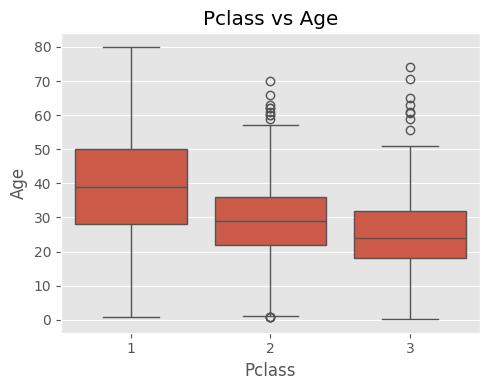

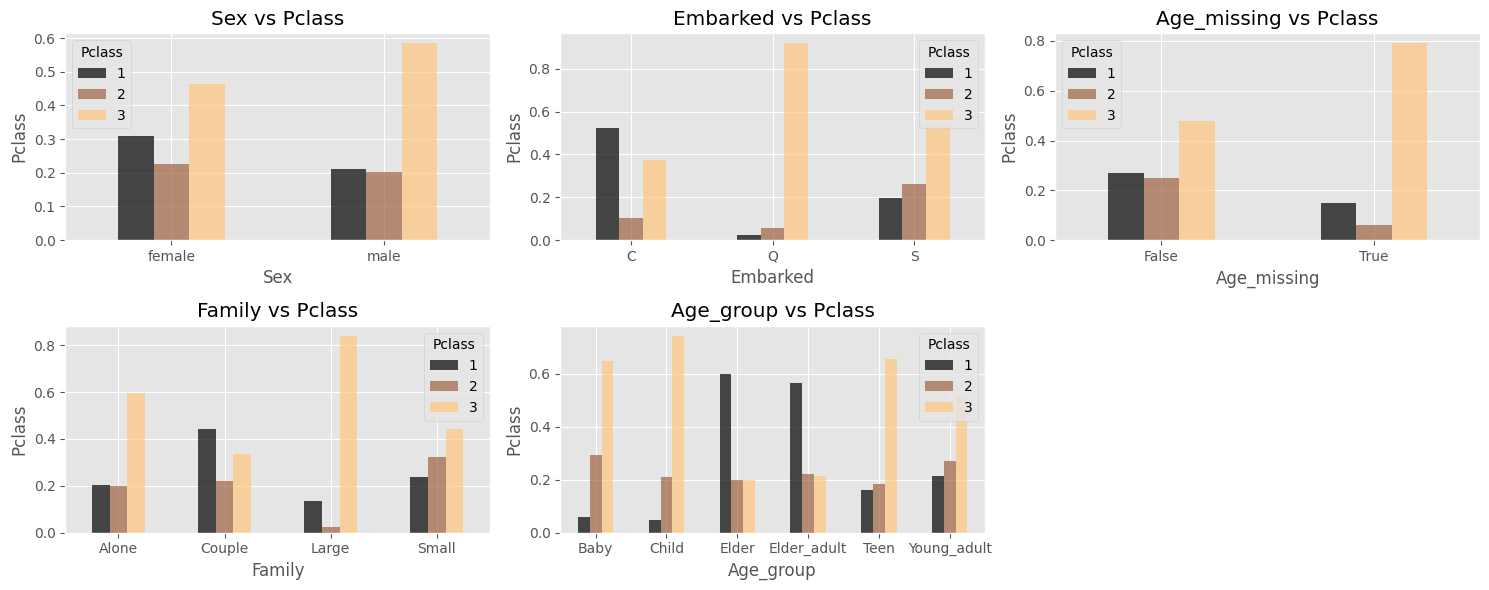

x (cat),y (cat),Chi2,p-value
Embarked,Pclass,204.484320,0.000000
Age_group,Pclass,158.103069,0.000000
Family,Pclass,113.110844,0.000000
Age_missing,Pclass,86.037319,0.000000
Sex,Pclass,20.378781,0.000038


In [17]:
x_cat_y_cont(data, x_cols='Pclass', y_cols='Age', kind='boxplot', ncols=2, test=False)
x_cat_y_cat(data, y_cols='Pclass', x_cols=['Sex', 'Embarked', 'Age_missing', 'Family', 'Age_group'], kind='barplot', ncols=3, test=True)

#### Respecto a la variable Sex

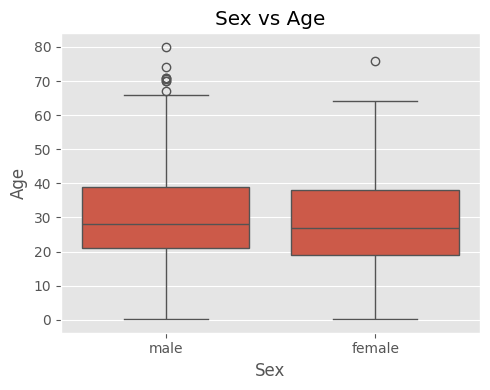

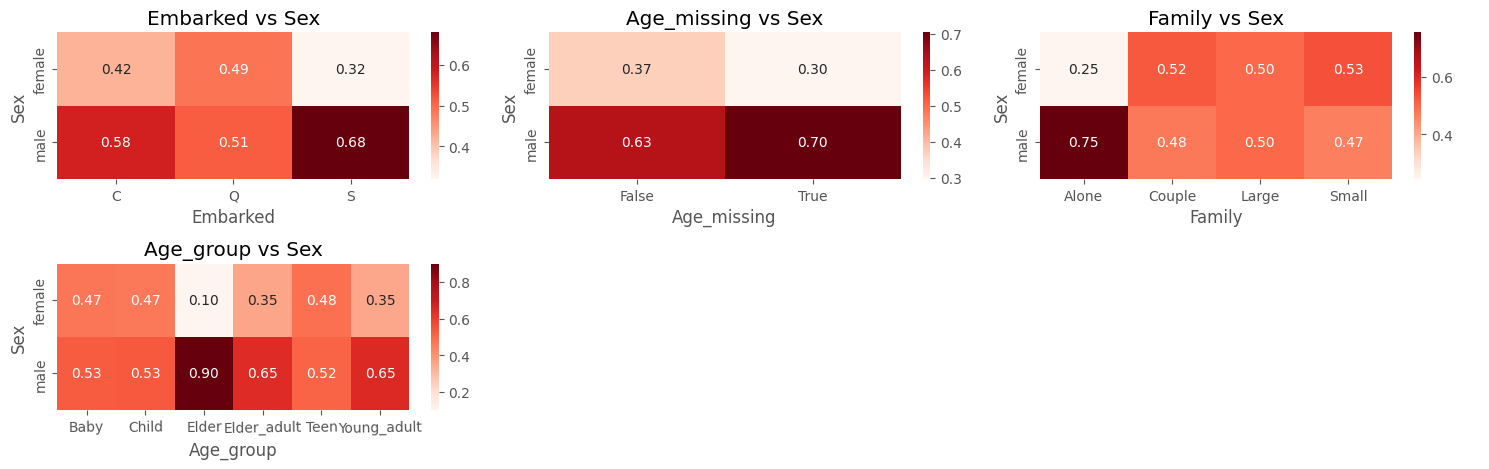

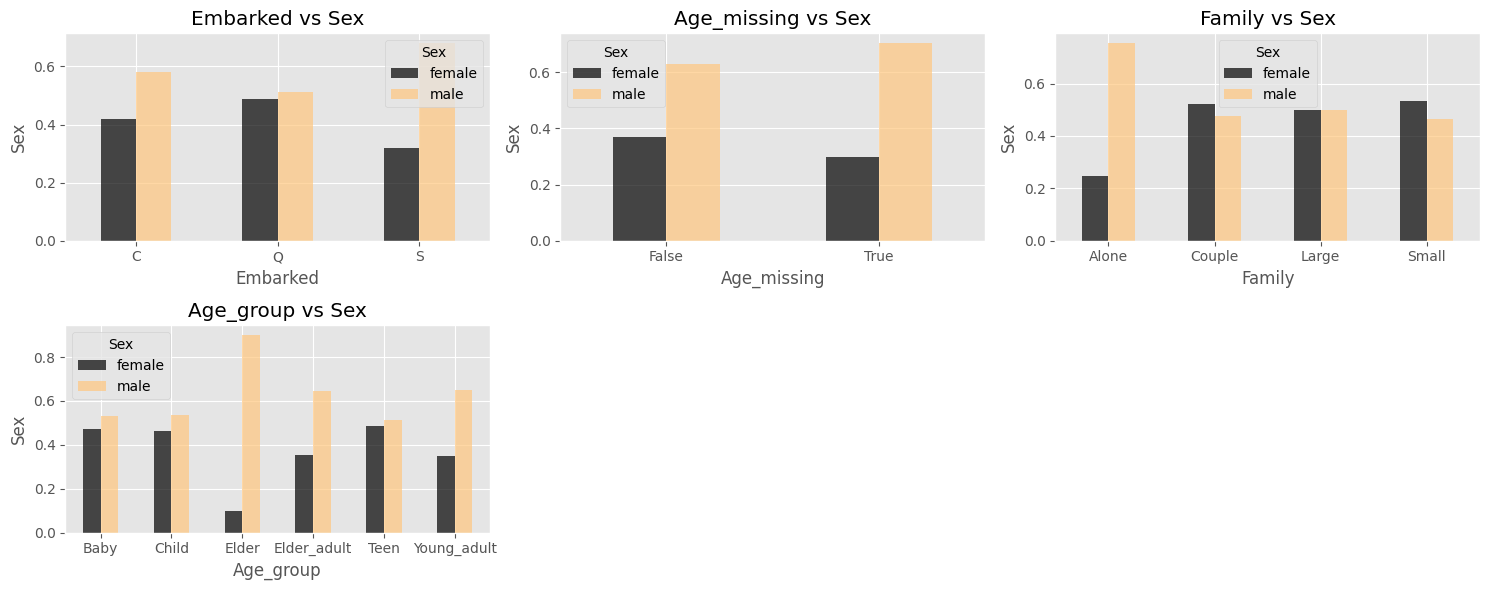

x (cat),y (cat),Chi2,p-value
Family,Sex,106.284988,0.000000
Embarked,Sex,19.139254,0.000070
Age_group,Sex,14.078716,0.015117
Age_missing,Sex,4.749358,0.029309


Media de edad mujeres: 29 
Media de edad hombres: 31

Porcentaje de menores masculino: 52.6%.
Porcentaje de adultos masculino: 73.2%.
Porcentaje de mayores masculino: 90.0%.


In [18]:
x_cat_y_cont(data, x_cols='Sex', y_cols='Age', kind='boxplot', ncols=1, test=False)
x_cat_y_cat(data, y_cols='Sex', x_cols=['Embarked', 'Age_missing', 'Family', 'Age_group'], kind='heatmap', ncols=3,
            test=False, rotation=[False, False, False, True])
x_cat_y_cat(data, y_cols='Sex', x_cols=['Embarked', 'Age_missing', 'Family', 'Age_group'], kind='barplot', ncols=3)

edad_media = data.groupby("Sex")["Age"].mean()
print(f"Media de edad mujeres: {edad_media['female']:.0f} \nMedia de edad hombres: {edad_media['male']:.0f}")

sex_agegroup = data.groupby('Age_group')['Sex'].value_counts(normalize=True)
print(f"\nPorcentaje de menores masculino: {sex_agegroup.loc[['Baby', 'Child', 'Teen'], 'male'].mean() * 100:.1f}%.")
print(f"Porcentaje de adultos masculino: {sex_agegroup.loc[['Young_adult', 'Elder_adult', 'Elder'], 'male'].mean() * 100:.1f}%.")
print(f"Porcentaje de mayores masculino: {sex_agegroup.loc['Elder', 'male'].mean() * 100:.1f}%.")

* Mujeres y hombres tienen edades más o menos similares.
* De entre los que viajan solos, un 75% son hombres. En la época era menos común que la mujer fuera sola.
* Se desconoce la edad en una proporción mucho mayor de hombres que de mujeres (coherente con la superviviencia).
* En Southampton hay más proporción de hombres que de mujeres, mientras que en Cherbourg y Queenstown es más igualado.
* De entre los menores, hay un 48% de género femenino. Entre los adultos un 26% y mayores solo un 10%.

#### Respecto a la variable Age

Finalmente, observamos la relación que tiene 'Age' con 'Embarked' y con 'Family', ya que otras relaciones restantes pueden ser menos interesantes.

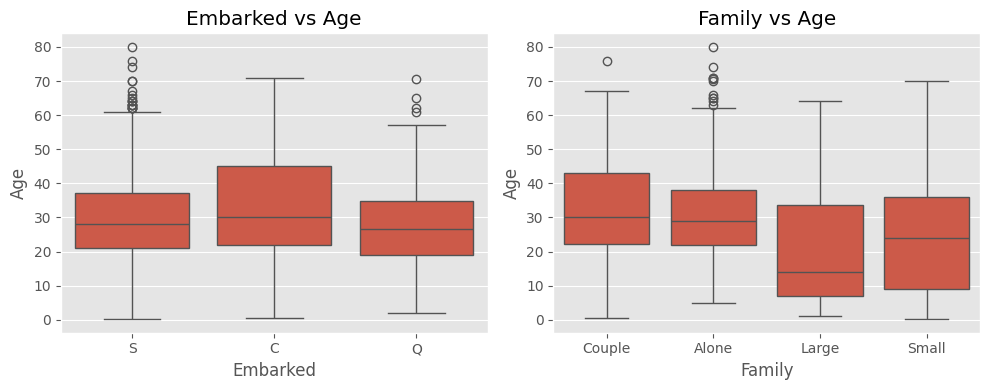

x (cat),y (cont),Estadístico de influencia de x sobre y,p-valor de influencia
Embarked,Age,Kruskal-Wallis,0.023296
Family,Age,Kruskal-Wallis,0.000000


Media de edad de pasajeros embarcados Southampton: 29
Media de edad de pasajeros embarcados Cherbourg: 32
Media de edad de pasajeros embarcados Queenstown: 29

Media de edad de pasajeros que viajaban solos: 32
Media de edad de pasajeros que viajaban en pareja: 33
Media de edad de pasajeros que viajaban en grupo pequeño: 25
Media de edad de pasajeros que viajaban en grupo grande: 20


In [19]:
x_cat_y_cont(data, x_cols=['Embarked', 'Family'], y_cols='Age', kind='boxplot', ncols=2)

print(f"Media de edad de pasajeros embarcados Southampton: {data[data['Embarked'] == 'S']['Age'].mean():.0f}")
print(f"Media de edad de pasajeros embarcados Cherbourg: {data[data['Embarked'] == 'C']['Age'].mean():.0f}")
print(f"Media de edad de pasajeros embarcados Queenstown: {data[data['Embarked'] == 'Q']['Age'].mean():.0f}")

print(f"\nMedia de edad de pasajeros que viajaban solos: {data[data['Family'] == 'Alone']['Age'].mean():.0f}")
print(f"Media de edad de pasajeros que viajaban en pareja: {data[data['Family'] == 'Couple']['Age'].mean():.0f}")
print(f"Media de edad de pasajeros que viajaban en grupo pequeño: {data[data['Family'] == 'Small']['Age'].mean():.0f}")
print(f"Media de edad de pasajeros que viajaban en grupo grande: {data[data['Family'] == 'Large']['Age'].mean():.0f}")

* Aunque no es muy grande la diferencia, los pasajeros de Cherbourg son en media algo mayores que los de Southamton y Queenstown.
* Los pasajeros acompañados por míninmo dos personas suelen ser más jóvenes. Si son acompañados por 4 o más personas tienen media de 20 años.

### Análisis Multivariante

Podemos ver entre las variables más influyentes están el sexo y el coste del billete. La siguiente gráfica lo muestra muy claro.

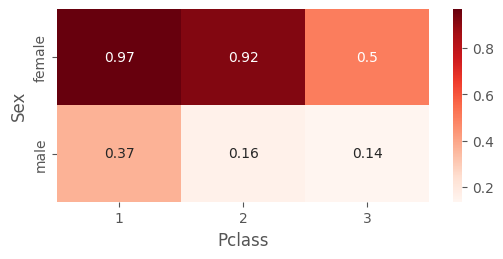

In [20]:
plt.subplots(figsize=(6,2.5))
sns.heatmap(data.pivot_table(index='Pclass', columns='Sex', values='Survived', aggfunc='mean').T, annot=True, cmap='Reds')
plt.show()

Es por ello que en el sentido descriptivo, sabremos si un pasajero tiene mayor probabilidad de supervivencia sabiendo si es mujer, de clase baja, con alto coste, con edad conocida, joven y acompañada por 1 a 3 personas.

Sin embargo, en el sentido de variables predictoras, es seguro que no todas son necesarias pues hay algunas variables pueden ser determinadas por otras. Por ejemplo, si conocemos el sexo y el coste del billete, Pclass queda en una gran parte determinado, como se puede ver en la figura de abajo (donde se han eliminado los cuatro valores de Fare extremos para una mejor visualización).

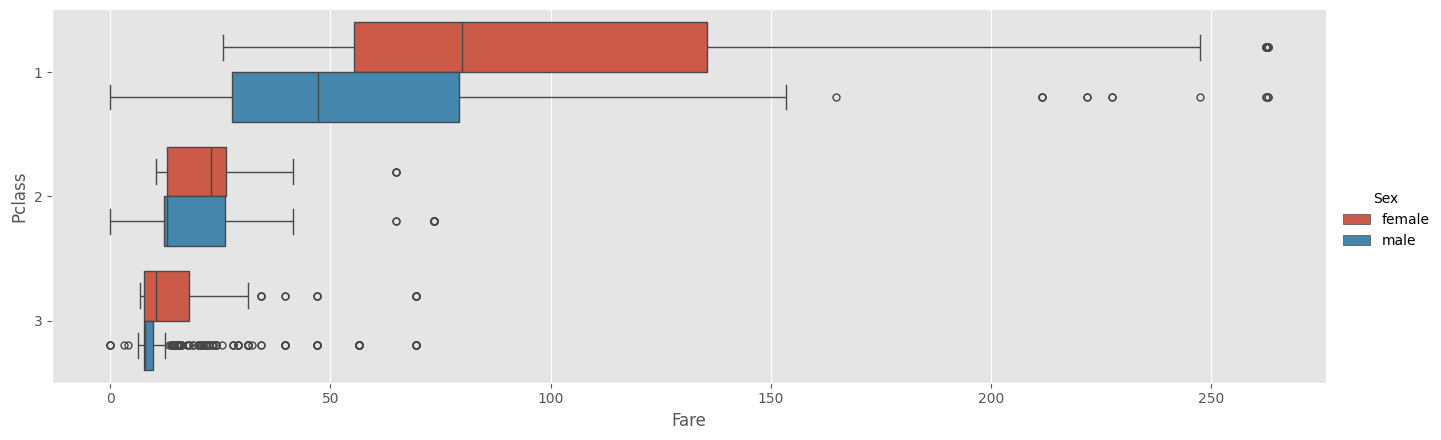

Pclass      1            2            3      
Sex    female  male female  male female  male
Fare    109.4  69.9   23.2  19.9   15.3  12.5

In [21]:
sns.catplot(x=data[data['Fare']<=300]['Fare'], y=data[data['Fare']<=300]['Pclass'], hue=data[data['Fare']<=300]['Sex'], kind='box', orient='h', height=4.5, aspect=3)
plt.show()

display(pd.DataFrame(data.groupby(['Pclass', 'Sex'])['Fare'].mean().round(1)).T)

Veremos entonces cuales son las variables más relevantes mediante RandomForest. Primero tratamos los datos.

Dividimos ahora el conjunto de datos imputados en X, con las filas etiquetadas, y X_test, con las no etiquetadas. Por ahora, no dividimos los datos de X en conjuntos de entrenamiento y validación debido a que ahora queremos entender cuales son las variables más relevantes a la hora de predecir si un pasajero sobrevive o no. Cuando entrenemos un modelo de predicción, lo dividiremos en tales conjuntos.

In [22]:
X = data_imputed.dropna()
X_test = data_imputed[data_imputed['Survived'].isnull()].drop('Survived', axis=1)

y = X.pop('Survived')

display(X.head(5), y.head(5), X_test.head(5))


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_missing,Family,Age_group,Fare_normalized
PassengerId,,,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,False,Couple,Young_adult,-0.905655
2,1,female,38.0,1,0,71.2833,C,False,Couple,Young_adult,1.319330
3,3,female,26.0,0,0,7.9250,S,False,Alone,Young_adult,-0.812585
4,1,female,35.0,1,0,53.1000,S,False,Couple,Young_adult,1.060161
5,3,male,35.0,0,0,8.0500,S,False,Alone,Young_adult,-0.796233


PassengerId
1    0.0
2    1.0
3    1.0
4    1.0
5    0.0
Name: Survived, dtype: float64

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_missing,Family,Age_group,Fare_normalized
PassengerId,,,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,False,Alone,Young_adult,-0.825296
893,3,female,47.0,1,0,7.0000,S,False,Couple,Elder_adult,-0.942353
894,2,male,62.0,0,0,9.6875,Q,False,Alone,Elder_adult,-0.603161
895,3,male,27.0,0,0,8.6625,S,False,Alone,Young_adult,-0.719666
896,3,female,22.0,1,1,12.2875,S,False,Small,Young_adult,-0.357121


Debido a que la función creada al principio 'preprocessor_creator' puede realizar la transformación Yeo-Johnson a aquellas variables introducidas en PowerT_cols, la eliminamos para introducirla si lo vemos conveniente.

In [23]:
X.drop('Fare_normalized', axis=1, inplace=True)
X_test.drop('Fare_normalized', axis=1, inplace=True)

C:\Users\prada\AppData\Local\Temp\ipykernel_19860\1259137284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('Fare_normalized', axis=1, inplace=True)


Vamos a realizar dos RandomForest con diferentes objetivos: el primero es comprender qué es importante para la supervivencia, el segundo es ver qué variables son las más importantes para predecirla.

Entonces, en este primer modelo mantendremos las variables artificiales 'Family' y 'Age_group' y eliminaremos las variables 'Age', 'Parch' y 'SibSp'.

In [24]:
preprocessor_rf = preprocessor_creator(OrdinalE_cols=['Sex'], OH_cols=['Pclass', 'Embarked', 'Family', 'Age_group'])

pipeline_rf = Pipeline([
    ('pre', preprocessor_rf),
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42))
])

pipeline_rf.fit(X.drop(['Age', 'Parch', 'SibSp'], axis=1), y)

importancias = pipeline_rf.named_steps['rf'].feature_importances_
nombres = pipeline_rf.named_steps['pre'].get_feature_names_out()
import_series = pd.Series(importancias, index=nombres).sort_values(ascending=False)
display(pd.DataFrame({'Influencia': (import_series*100).round(1), 
                      'Acumulado':(import_series.cumsum()*100).round(1)}))

,Influencia,Acumulado
Fare,35.2,35.2
Sex,29.1,64.3
Pclass_3,5.5,69.8
Pclass_1,3.4,73.2
Age_missing,2.6,75.8
Age_group_Baby,2.6,78.4
Family_Small,2.5,81.0
Family_Large,2.3,83.3
Family_Alone,2.2,85.5
Age_group_Young_adult,2.2,87.7


Como podemos ver, lo más importante para este modelo es comprobar el coste del billete, después el sexo, luego saber si es 1º o 3º clase. Posteriormente, RandomForest considera saber si la edad del pasajero es conocida o si es bebé, ya que tienen mayor porcentaje de supervivencia.

Sólo con estas 6 primeras variables ya podemos explicar un 78% de los datos. Además podemos destacar que la variable Embarked es poco interesante.

A continuación, tratemos con las variables 'Age', 'Parch' y 'SibSp', en lugar de 'Age_group' y 'Family'. Esto implicará en mejores resultados, aunque desconoceremos a priori como utiliza RandomForest estos datos (por ejemplo, podemos ver en el entrenamiento anterior que de 'Age' lo más relevante es saber si es o no bebé).

In [25]:
preprocessor_rf = preprocessor_creator(OrdinalE_cols=['Sex'], OH_cols=['Pclass', 'Embarked'], OH_drop='first')

pipeline_rf = Pipeline([
    ('pre', preprocessor_rf),
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42))
])

pipeline_rf.fit(X.drop(['Age_group', 'Family'], axis=1), y)

importancias = pipeline_rf.named_steps['rf'].feature_importances_
nombres = pipeline_rf.named_steps['pre'].get_feature_names_out()
import_series = pd.Series(importancias, index=nombres).sort_values(ascending=False)
display(pd.DataFrame({'Influencia': (import_series*100).round(1), 
                      'Acumulado':(import_series.cumsum()*100).round(1)}))

,Influencia,Acumulado
Fare,26.8,26.8
Sex,26.6,53.4
Age,24.2,77.6
Pclass_3,6.9,84.5
SibSp,5.0,89.5
Parch,3.8,93.3
Embarked_S,2.3,95.7
Pclass_2,1.7,97.4
Age_missing,1.6,99.0
Embarked_Q,1.0,100.0


Como podemos ver ahora con las 5 primeras variables ('Fare', 'Sex', 'Age', 'Pclass_3' y 'SibSp') podemos explicar un 90% de los datos. En este caso, la variable 'Age' a cobrado mucha más importancia que 'Age_group' debido a que 'Age' contiene mucha más información al no estar agrupada. Solo sabiendo el precio del billete, el sexo y la edad llegamos a un 77%.

El gráfico de abajo muestra la enorme influencia de 'Fare' y 'Sex' en la superviviencia.

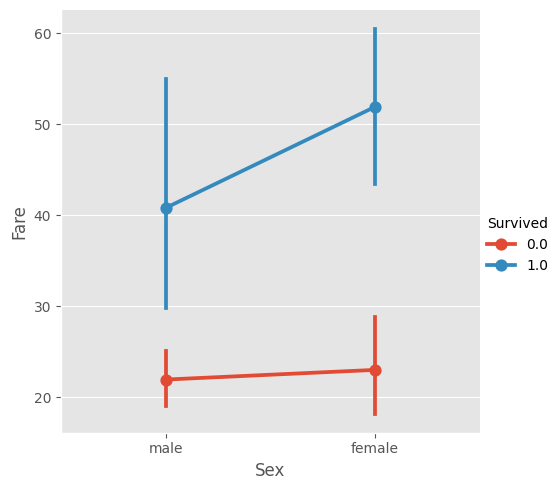

In [26]:
sns.catplot(data=data, x='Sex', y='Fare', hue='Survived', kind='point')
plt.show()

# Entrenamiento de modelos

A continuación, descartaremos 'Age_group' y 'Family' por dos motivos: reducción de variables (por no tener que hacer OneHotEncoder) y debido a que 'Age', 'SibSp' y 'Parch' contienen más información.

No dividimos 'X' e 'y' en conjuntos de entrenamiento y validación ya realizaremos entrenamiento por validación cruzada.

### Preprocesadores

No todos los modelos se benefician del mismo preprocesamiento. Por ejemplo, los modelos lineales requieren de escalado de los datos, mientras que los modelos de árbol de decisión no lo requieren. Por lo tanto, es recomendable crear diferentes preprocesadores para diferentes modelos.

Crearemos 2 preprocesadores: 

1. preprocessor: Solo cambiará a numéricas las etiquetas de 'Sex' y aplicará OneHotEncoder a 'Embarked' y 'Pclass', iliminando una de las caracteristicas en OneHotEncoder para evitar multicolinealidad.
2. preprocessor_escalado: Aplicamos además una transformación de Yeo-Johnson para normalizar 'Fare' y 'Age' y, después, aplicamos RobustScaler a 'Age', 'Fare', 'SibSp' y 'Parch'.

El primero será apropiado para mdoelos modelos que no necesitan reescalado, como AdaBoostClassifier, RandomForestClassifier o XGBClassifier. El segundo será apropiado para modelos que requieren escalado, como LogisticRegressionCV, SGDClassifier o SVC.

In [27]:
preprocessor = preprocessor_creator(OrdinalE_cols=['Sex'], OH_cols=['Embarked', 'Pclass'], OH_drop='first')
preprocessor_scaled = preprocessor_creator(OrdinalE_cols=['Sex'], OH_cols=['Embarked', 'Pclass'], RScaler_cols=['Age', 'Fare', 'SibSp', 'Parch'], PowerT_cols=['Fare', 'Age'], OH_drop='first')

### Entrenamiento

Realizaremos un entrenamiento de varios modelos para ver cual tiene mejor performance. Aquel o aquellos modelos que obtengan mejores resultados realizaremos un tuneo de hiperparametros para potenciarlo.

In [28]:
estimators = [
    # Ensemble methods
    ('AdaBoostClassifier', AdaBoostClassifier(random_state=42), preprocessor, None),
    ('BaggingClassifier', BaggingClassifier(n_jobs=-1, random_state=42), preprocessor, None),
    ('ExtraTreesClassifier', ExtraTreesClassifier(n_jobs=-1, random_state=42), preprocessor, None),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42), preprocessor, None),
    ('RandomForestClassifier', RandomForestClassifier(n_jobs=-1, random_state=42), preprocessor, None),
    ('HistGradientBoostingClassifier', HistGradientBoostingClassifier(random_state=42), preprocessor, None),

    # Tree-based models
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42), preprocessor, None),

    # XGBoost
    ('XGBClassifier', XGBClassifier(random_state=42), preprocessor, None),

    # GLM
    ('LogisticRegressionCV', LogisticRegressionCV(n_jobs=-1, random_state=42), preprocessor_scaled, None),
    ('SGDClassifier', SGDClassifier(n_jobs=-1, random_state=42), preprocessor_scaled, None),

    # Nearest neighbors
    ('KNeighborsClassifier', KNeighborsClassifier(n_jobs=-1), preprocessor_scaled, None),

    # SVM
    ('SVC', SVC(random_state=42), preprocessor_scaled, None),
    ('LinearSVC', SVC(kernel='linear', random_state=42), preprocessor_scaled, None),
    ('Poly2SVC', SVC(kernel='poly', degree=2, random_state=42), preprocessor_scaled, None),
    ('Poly3SVC', SVC(kernel='poly', degree=3, random_state=42), preprocessor_scaled, None),

    # Discriminant Analysis
    ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis(), preprocessor_scaled, None)
]

Tras probar con varios conjuntos de variables, con resultados algunos bastante similares, los mejores se obtienen con todas las variables del modelo original.

In [29]:
todos_los_modelos = trainer(X.drop(['Age_group', 'Family'], axis=1), y, models=estimators)

➡️ Entrenado AdaBoostClassifier: F1 = 0.7335
➡️ Entrenado BaggingClassifier: F1 = 0.7397
➡️ Entrenado ExtraTreesClassifier: F1 = 0.7215
➡️ Entrenado GradientBoostingClassifier: F1 = 0.7475
➡️ Entrenado RandomForestClassifier: F1 = 0.7434
➡️ Entrenado HistGradientBoostingClassifier: F1 = 0.7402
➡️ Entrenado DecisionTreeClassifier: F1 = 0.6972
➡️ Entrenado XGBClassifier: F1 = 0.7406
➡️ Entrenado LogisticRegressionCV: F1 = 0.7106
➡️ Entrenado SGDClassifier: F1 = 0.6746
➡️ Entrenado KNeighborsClassifier: F1 = 0.7454
➡️ Entrenado SVC: F1 = 0.7418
➡️ Entrenado LinearSVC: F1 = 0.7101
➡️ Entrenado Poly2SVC: F1 = 0.7564
➡️ Entrenado Poly3SVC: F1 = 0.7460
➡️ Entrenado LinearDiscriminantAnalysis: F1 = 0.7203


,F1,Accuracy,Precission,Recall,AUC
Poly2SVC,0.756375,0.824889,0.813086,0.707673,0.854582
GradientBoostingClassifier,0.747484,0.819271,0.812623,0.696164,0.866515
Poly3SVC,0.745989,0.811412,0.772239,0.722208,0.849721
KNeighborsClassifier,0.745402,0.811431,0.774527,0.719480,0.840793
RandomForestClassifier,0.743440,0.808066,0.764327,0.725277,0.854610
SVC,0.741790,0.819271,0.825752,0.675448,0.845642
XGBClassifier,0.740628,0.806917,0.766003,0.719352,0.852160
HistGradientBoostingClassifier,0.740238,0.810313,0.778743,0.707843,0.860138
BaggingClassifier,0.739679,0.808047,0.773123,0.710742,0.849206
AdaBoostClassifier,0.733523,0.797947,0.745558,0.722293,0.845473


Realizamos un tuneo de hiperparametros para los mejores tres modelos. Además, por elección propia, añado los modelos RandomForestClassifier, XGBClassifier y AdaBoostClassifier, debido a su buen desempeño en muchas situaciones a seleccionar mejor los hiperparametros.

In [31]:
# 1) SVC polinómico grado 2
param_grid_poly2 = {
    'model__C':       [0.01, 0.1, 1, 10, 100],
    'model__gamma':   ['scale', 'auto', 0.01, 0.1, 1],
    'model__coef0':   [0.0, 0.5, 1.0, 2.0],
    # degree ya fijo en 2
}

# 2) GradientBoostingClassifier clásico
param_grid_gb = {
    'model__n_estimators':       [500],
    'model__learning_rate':      [0.01, 0.05, 0.1, 0.2],
    'model__max_depth':          [3, 5, 7, None],
    'model__min_samples_split':  [2, 5, 10],
    'model__min_samples_leaf':   [1, 2, 4],
}

# 3) SVC polinómico grado 3
param_grid_poly3 = {
    'model__C':       [0.01, 0.1, 1, 10, 100],
    'model__gamma':   ['scale', 'auto', 0.01, 0.1, 1],
    'model__coef0':   [0.0, 0.5, 1.0, 2.0],
    # degree ya fijo en 3
}

# 4) RandomForestClassifier
param_grid_rf = {
    'model__n_estimators':       [100, 200, 300],
    'model__max_depth':          [None, 10, 20],
    'model__min_samples_split':  [2, 5],
    'model__max_features':       ['sqrt', 'log2']
}

# 2) XGBClassifier
param_grid_xgb = {
    'model__n_estimators':       [100, 200],
    'model__learning_rate':      [0.05, 0.1, 0.2],
    'model__max_depth':          [3, 5, 7],
    'model__subsample':          [0.8, 1.0]
}

# 3) AdaBoostClassifier
param_grid_ada = {
    'model__n_estimators':       [50, 100, 200],
    'model__learning_rate':      [0.01, 0.1, 0.5, 1.0],
    'model__algorithm':          ['SAMME', 'SAMME.R']
}

models = [('Poly2SVC', SVC(kernel='poly', degree=2, random_state=42), preprocessor_scaled, param_grid_poly2),
          ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42), preprocessor, param_grid_gb),
          ('Poly3SVC', SVC(kernel='poly', degree=3, random_state=42), preprocessor_scaled, param_grid_poly3),
          ('RandomForestClassifier', RandomForestClassifier(n_jobs=-1, random_state=42), preprocessor, param_grid_rf),
          ('XGBClassifier', XGBClassifier(random_state=42, eval_metric='logloss'), preprocessor, param_grid_xgb),
          ('AdaBoostClassifier', AdaBoostClassifier(random_state=42), preprocessor, param_grid_ada)]

best_models = trainer(X.drop(['Age_group', 'Family'], axis=1), y, models=models)

➡️ Entrenado Poly2SVC: F1 = 0.7599
   ✨ Mejores parámetros:


,model__C,model__coef0,model__gamma
0,0.01,0.5,1


➡️ Entrenado GradientBoostingClassifier: F1 = 0.7664
   ✨ Mejores parámetros:


,model__learning_rate,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,0.01,5,4,2,500


➡️ Entrenado Poly3SVC: F1 = 0.7607
   ✨ Mejores parámetros:


,model__C,model__coef0,model__gamma
0,0.1,1.0,scale


➡️ Entrenado RandomForestClassifier: F1 = 0.7651
   ✨ Mejores parámetros:


,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
0,10,sqrt,5,200


➡️ Entrenado XGBClassifier: F1 = 0.7708
   ✨ Mejores parámetros:


,model__learning_rate,model__max_depth,model__n_estimators,model__subsample
0,0.2,3,200,1.0


➡️ Entrenado AdaBoostClassifier: F1 = 0.7403
   ✨ Mejores parámetros:


,model__algorithm,model__learning_rate,model__n_estimators
0,SAMME.R,0.5,100


,F1,Accuracy,Precission,Recall,AUC
XGBClassifier,0.770817,0.830500,0.803609,0.742796,0.862567
GradientBoostingClassifier,0.766390,0.831618,0.821430,0.719395,0.859374
RandomForestClassifier,0.765126,0.830494,0.819662,0.719480,0.863594
Poly3SVC,0.760744,0.827123,0.811277,0.716411,0.847854
Poly2SVC,0.759881,0.824889,0.802169,0.722293,0.857199
AdaBoostClassifier,0.740322,0.801299,0.744594,0.736999,0.847613


El mejor modelo ha sido XGBClassifier con un F1-score de 0.77 y un accuracy de 0.830, seguido muy de cerca por GradientBoostingClassifier con un F1-score de 0.766 y un accuracy de 0.831.

Recuperamos el mejor modelo y realizamos una predicción de los datos de test.

In [39]:
best_model = best_models['XGBClassifier']

y_pred = best_model.predict(X_test)
pd.DataFrame(y_pred, index=X_test.index, columns=['Survived']).to_csv('submission.csv')